In [1]:
# === MF 0–1 error plotter (notebook-friendly) ===
import os, re, json, math, glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def phi_cdf(x: float) -> float:
    """Standard normal CDF without SciPy."""
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def parse_meta_from_filename(path):
    """
    Extract kappa, P, M_noise from filenames like:
      ..._kap1.000e-03_P750_K4_M2048_it4000_B1024.json
    Returns (kappa_float, P_int, M_noise_int) or (None, None, None).
    """
    fname = os.path.basename(path)
    mk = re.search(r"_kap([0-9eE\+\-\.]+)", fname)
    mp = re.search(r"_P(\d+)", fname)
    mm = re.search(r"_M(\d+)", fname)
    try:
        kappa = float(mk.group(1)) if mk else None
        P = int(mp.group(1)) if mp else None
        M_noise = int(mm.group(1)) if mm else None
        return kappa, P, M_noise
    except Exception:
        return None, None, None

def estimate_err01_from_file(path, iter_index=-1, vnoise_floor=1e-16):
    """
    Estimate MF 0–1 error for one JSON file at a chosen iteration (default: final).
    Uses CLT surrogate: err ≈ Φ( - mS / sqrt(V_noise) ), where V_noise = M_noise * RMS_noise^2.
    Returns dict or None on failure.
    """
    kappa, P, M_noise = parse_meta_from_filename(path)
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except Exception:
        return None

    # Try to fill missing metadata from JSON (kappa, P); M_noise must come from filename
    if kappa is None:
        kappa = data.get("summary", {}).get("kappa", None)
    if P is None:
        P = data.get("summary", {}).get("P", None)
    if (kappa is None) or (P is None) or (M_noise is None):
        return None

    traj = data.get("trajectories", {})
    mS_per_iter = traj.get("m_S_per_iter", None)
    noise_rms_per_iter = traj.get("m_noise_rms_per_iter", None)
    if not mS_per_iter or not noise_rms_per_iter:
        return None

    try:
        mS = np.array(mS_per_iter[iter_index], dtype=float)      # shape: (blocks,)
        rms = np.array(noise_rms_per_iter[iter_index], dtype=float)
    except Exception:
        return None

    good = np.isfinite(mS) & np.isfinite(rms)
    if not np.any(good):
        return None
    mS = mS[good]
    rms = rms[good]

    # V_noise = sum_{A≠S} m_A^2 = (M_noise) * (RMS_noise)^2
    V_noise = (M_noise) * (rms ** 2)
    V_noise = np.maximum(V_noise, vnoise_floor)

    snr = mS / np.sqrt(V_noise)
    err01 = np.array([phi_cdf(-float(s)) for s in snr], dtype=float)

    return {
        "kappa": float(kappa),
        "P": int(P),
        "M_noise": int(M_noise),
        "err01_block_mean": float(err01.mean()),
        "err01_block_std": float(err01.std(ddof=0)),
        "n_blocks": int(err01.size),
        "file": path,
    }

def aggregate_by_kappa_P(rows):
    """
    Aggregate rows with the same (kappa, P) by weighting their means by #blocks.
    Returns list of aggregated dicts.
    """
    groups = defaultdict(list)
    for r in rows:
        groups[(r["kappa"], r["P"])].append(r)

    agg = []
    for (kappa, P), rs in groups.items():
        weights = np.array([r["n_blocks"] for r in rs], dtype=float)
        vals = np.array([r["err01_block_mean"] for r in rs], dtype=float)
        mean = float(np.average(vals, weights=weights))
        std_over_runs = float(np.std(vals, ddof=0))   # variability across files
        total_blocks = int(np.sum(weights))
        M_noise = rs[0]["M_noise"]
        agg.append({
            "kappa": float(kappa),
            "P": int(P),
            "M_noise": int(M_noise),
            "err01_mean": mean,
            "err01_std_over_runs": std_over_runs,
            "n_runs": len(rs),
            "total_blocks": total_blocks,
        })
    return agg

def plot_err_vs_P(agg_rows, title=None):
    """
    Plot err01_mean vs P, color-coded by kappa. Returns (fig, ax).
    """
    by_kappa = defaultdict(list)
    for r in agg_rows:
        by_kappa[r["kappa"]].append(r)

    fig, ax = plt.subplots(figsize=(8, 5))
    for kappa in sorted(by_kappa.keys()):
        rows = sorted(by_kappa[kappa], key=lambda r: r["P"])
        Ps = [r["P"] for r in rows]
        errs = [r["err01_mean"] for r in rows]
        yerr = [r["err01_std_over_runs"] for r in rows]
        label = f"κ = {kappa:g}"
        ax.errorbar(Ps, errs, yerr=yerr, capsize=3, marker="o", linestyle="-", label=label)

    ax.set_xlabel("Dataset size P")
    ax.set_ylabel("Estimated 0–1 error (MF, CLT surrogate)")
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig, ax

def make_plot_from_dir(results_dir, iter_index=-1, save_png=True, png_name="mf_estimated_01_vs_P.png"):
    """
    Scan a directory for *.json, compute MF 0–1 error per file (final iter by default),
    aggregate by (kappa,P), and plot.
    """
    paths = glob.glob(os.path.join(results_dir, "*.json"))
    rows = []
    for p in paths:
        r = estimate_err01_from_file(p, iter_index=iter_index)
        if r is not None:
            rows.append(r)

    if not rows:
        print("No usable JSON files found (or unable to parse κ, P, M_noise).")
        return None

    agg = aggregate_by_kappa_P(rows)

    # Console summary (nice in notebooks too)
    print("Aggregated by (κ, P):")
    for r in sorted(agg, key=lambda t: (t["kappa"], t["P"])):
        print(f"  κ={r['kappa']:g}  P={r['P']:>6d}  "
              f"err01_mean={r['err01_mean']:.4f}  runs={r['n_runs']}  "
              f"blocks={r['total_blocks']}  M_noise={r['M_noise']}")

    fig, ax = plot_err_vs_P(agg, title="MF-estimated 0–1 error vs P")

    if save_png:
        out_png = os.path.join(results_dir, png_name)
        fig.savefig(out_png, dpi=150)
        print(f"[saved plot] {out_png}")

    return {"agg": agg, "fig": fig, "ax": ax}

# ==== Example usage (Notebook) ====
# Set your directory with saved JSONs:
results_dir = "/home/goring/mean_field_langevin/MCMC_finiteP/results/2208_grid_testpaul"
out = make_plot_from_dir(results_dir, iter_index=-1, save_png=False)
out["fig"]  # shows inline in a notebook



No usable JSON files found (or unable to parse κ, P, M_noise).


TypeError: 'NoneType' object is not subscriptable

Aggregated by (κ, P):
  κ=0.001  P=    10  err01_mean=0.5000  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   100  err01_mean=0.4735  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   250  err01_mean=0.4455  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   500  err01_mean=0.4451  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   600  err01_mean=0.4644  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   700  err01_mean=0.4641  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   800  err01_mean=0.3735  runs=1  blocks=1  M_noise_eff≈2451.0


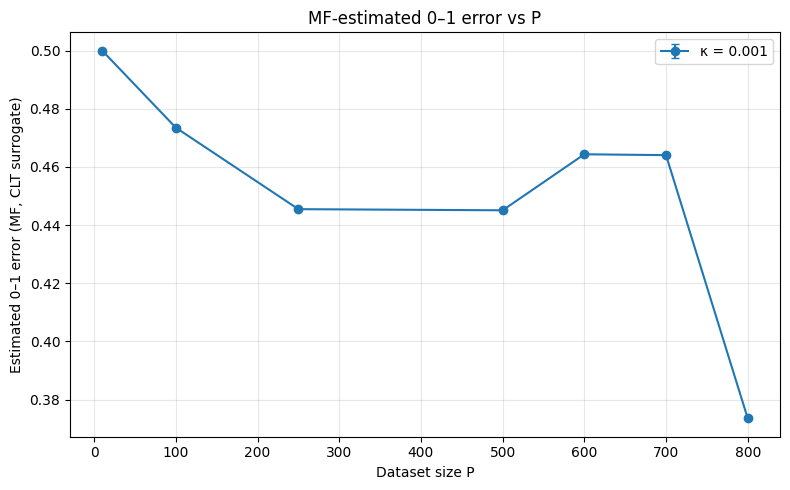

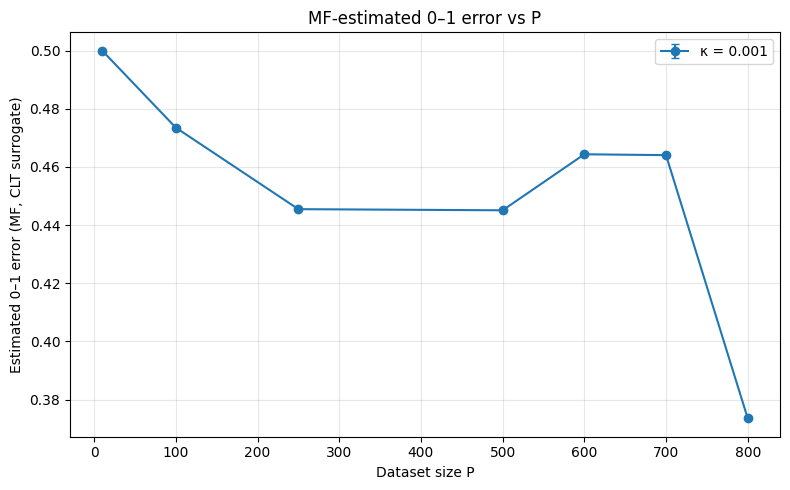

In [4]:
# === MF 0–1 error plotter (adapted for 0908_der3_nospecialsplit_finiteP_multi_simblocks_fullvar4.py) ===
import os, re, json, math, glob
from collections import defaultdict
from math import comb
import numpy as np
import matplotlib.pyplot as plt

def phi_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

# ---------- helpers to match the new training output ----------

def parse_meta_from_filename(path):
    """
    Extract kappa, P (and optionally K) from filenames like:
      quenched_parallel_xfit_<tag>_kap1.000e-03_P750_K4.json
    Returns (kappa_float|None, P_int|None, K_int|None).
    """
    fname = os.path.basename(path)
    mk = re.search(r"_kap([0-9eE\+\-\.]+)", fname)
    mp = re.search(r"_P(\d+)", fname)
    kblk = re.search(r"_K(\d+)", fname)
    try:
        kappa = float(mk.group(1)) if mk else None
        P = int(mp.group(1)) if mp else None
        K = int(kblk.group(1)) if kblk else None
        return kappa, P, K
    except Exception:
        return None, None, None

def estimate_M_noise_from_BASE(base: dict) -> int:
    """
    Reconstruct # of tracked 'noise' modes (all modes except the teacher)
    from BASE settings used by build_modes_index_varcard(…).

    Rules:
      - Include ALL combos for cardinalities c=1..card_track_max,
        except remove the teacher when c == k.
      - For c > card_track_max: include min(sample_high_per_card, C(d,c)) per degree.
    """
    if not isinstance(base, dict):
        return None
    d = int(base.get("d", 0))
    k = int(base.get("k", 0))
    card_track_max = int(base.get("card_track_max", 0))
    sample_high_per_card = int(base.get("sample_high_per_card", 0))
    if d <= 0:
        return None

    M_noise = 0
    for c in range(1, d + 1):
        nc = comb(d, c)
        if c <= card_track_max:
            add = nc
            if c == k:
                # build_modes_index_varcard drops the teacher at this cardinality
                add = max(add - 1, 0)
        else:
            add = min(sample_high_per_card, nc) if sample_high_per_card > 0 else 0
        M_noise += add
    return int(M_noise)  # excludes the teacher by construction

# ---------- core computation ----------

def estimate_err01_from_file(path, iter_index=-1, vnoise_floor=1e-16):
    """
    Estimate MF 0–1 error per file at iteration 'iter_index' (default: final).
    Uses CLT surrogate: err ≈ Φ( - mS / sqrt(V_noise) ), with
      V_noise = M_noise * (RMS_noise)^2,
    where RMS_noise is saved by the training code as sqrt(mean_A m_A^2) over A≠S.
    Returns dict or None on failure.
    """
    kappa_f, P_f, _K = parse_meta_from_filename(path)
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except Exception:
        return None

    # Fill/override from JSON when available
    summary = data.get("summary", {})
    base = summary.get("BASE", {}) or data.get("BASE", {})

    kappa = kappa_f if kappa_f is not None else summary.get("kappa", None)
    P     = P_f     if P_f     is not None else summary.get("P", None)

    if (kappa is None) or (P is None):
        return None

    # Reconstruct M_noise from BASE (preferred path for var-card tracking)
    M_noise = estimate_M_noise_from_BASE(base)

    # If BASE didn’t have var-card info, try legacy filename pattern _M(\d+)
    if M_noise in (None, 0):
        mm = re.search(r"_M(\d+)", os.path.basename(path))
        M_noise = int(mm.group(1)) if mm else None

    # As a last resort, assume 1 (keeps plotting alive, but warns)
    m_noise_source = "base" if M_noise is not None else "fallback=1"
    if M_noise is None:
        M_noise = 1

    traj = data.get("trajectories", {})
    mS_per_iter = traj.get("m_S_per_iter", None)
    noise_rms_per_iter = traj.get("m_noise_rms_per_iter", None)
    if not mS_per_iter or not noise_rms_per_iter:
        return None

    try:
        mS  = np.array(mS_per_iter[iter_index], dtype=float)       # (blocks,)
        rms = np.array(noise_rms_per_iter[iter_index], dtype=float)
    except Exception:
        return None

    good = np.isfinite(mS) & np.isfinite(rms)
    if not np.any(good):
        return None
    mS  = mS[good]
    rms = rms[good]

    # V_noise = sum_A m_A^2  =  M_noise * mean_A(m_A^2)  =  M_noise * (RMS_noise)^2
    V_noise = (float(M_noise)) * (rms ** 2)
    V_noise = np.maximum(V_noise, vnoise_floor)

    snr = mS / np.sqrt(V_noise)
    err01 = np.array([phi_cdf(-float(s)) for s in snr], dtype=float)

    return {
        "kappa": float(kappa),
        "P": int(P),
        "M_noise": int(M_noise),
        "err01_block_mean": float(err01.mean()),
        "err01_block_std": float(err01.std(ddof=0)),
        "n_blocks": int(err01.size),
        "file": path,
        "M_noise_source": m_noise_source,
    }

def aggregate_by_kappa_P(rows):
    """
    Aggregate rows with the same (kappa, P) weighting by #blocks.
    """
    groups = defaultdict(list)
    for r in rows:
        groups[(r["kappa"], r["P"])].append(r)

    agg = []
    for (kappa, P), rs in groups.items():
        weights = np.array([r["n_blocks"] for r in rs], dtype=float)
        vals    = np.array([r["err01_block_mean"] for r in rs], dtype=float)
        mean = float(np.average(vals, weights=weights))
        std_over_runs = float(np.std(vals, ddof=0))
        total_blocks = int(np.sum(weights))
        # prefer consistent M_noise; if mixed, take weighted average (informative print only)
        m_vals = np.array([r["M_noise"] for r in rs], dtype=float)
        M_noise_eff = float(np.average(m_vals, weights=weights))
        agg.append({
            "kappa": float(kappa),
            "P": int(P),
            "M_noise_eff": M_noise_eff,
            "err01_mean": mean,
            "err01_std_over_runs": std_over_runs,
            "n_runs": len(rs),
            "total_blocks": total_blocks,
        })
    return agg

def plot_err_vs_P(agg_rows, title=None):
    """
    Plot err01_mean vs P, color-coded by kappa. Returns (fig, ax).
    """
    by_kappa = defaultdict(list)
    for r in agg_rows:
        by_kappa[r["kappa"]].append(r)

    fig, ax = plt.subplots(figsize=(8, 5))
    for kappa in sorted(by_kappa.keys()):
        rows = sorted(by_kappa[kappa], key=lambda r: r["P"])
        Ps   = [r["P"] for r in rows]
        errs = [r["err01_mean"] for r in rows]
        yerr = [r["err01_std_over_runs"] for r in rows]
        label = f"κ = {kappa:g}"
        ax.errorbar(Ps, errs, yerr=yerr, capsize=3, marker="o", linestyle="-", label=label)

    ax.set_xlabel("Dataset size P")
    ax.set_ylabel("Estimated 0–1 error (MF, CLT surrogate)")
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig, ax

def make_plot_from_dir(results_dir, iter_index=-1, save_png=True, png_name="mf_estimated_01_vs_P.png"):
    """
    Scan a directory for *.json produced by the training script, compute MF 0–1 error
    at the chosen iteration (default: final), aggregate by (kappa,P), and plot.
    """
    paths = glob.glob(os.path.join(results_dir, "*.json"))
    rows = []
    for p in paths:
        r = estimate_err01_from_file(p, iter_index=iter_index)
        if r is not None:
            rows.append(r)

    if not rows:
        print("No usable JSON files found (or unable to parse κ, P / read trajectories).")
        return None

    agg = aggregate_by_kappa_P(rows)

    # Console summary (nice in notebooks too)
    print("Aggregated by (κ, P):")
    for r in sorted(agg, key=lambda t: (t["kappa"], t["P"])):
        print(f"  κ={r['kappa']:g}  P={r['P']:>6d}  "
              f"err01_mean={r['err01_mean']:.4f}  runs={r['n_runs']}  "
              f"blocks={r['total_blocks']}  M_noise_eff≈{r['M_noise_eff']:.1f}")

    fig, ax = plot_err_vs_P(agg, title="MF-estimated 0–1 error vs P")

    if save_png:
        out_png = os.path.join(results_dir, png_name)
        fig.savefig(out_png, dpi=150)
        print(f"[saved plot] {out_png}")

    return {"agg": agg, "fig": fig, "ax": ax}

results_dir = "/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_32k_2000"
out = make_plot_from_dir(results_dir, iter_index=-1, save_png=False)
out["fig"]  # in a notebook



Aggregated by (κ, P):
  κ=0.001  P=    10  err01_mean=0.4880  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   100  err01_mean=0.4557  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   250  err01_mean=0.4547  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   500  err01_mean=0.4557  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   600  err01_mean=0.4532  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   700  err01_mean=0.4652  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   800  err01_mean=0.3741  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   900  err01_mean=0.3137  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=  1000  err01_mean=0.3413  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=  2000  err01_mean=0.2437  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=  5000  err01_mean=0.0960  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.01  P=    10  err01_mean=0.5000  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.01  P=   100  err01_mean=0.4906  runs=1  blocks=1

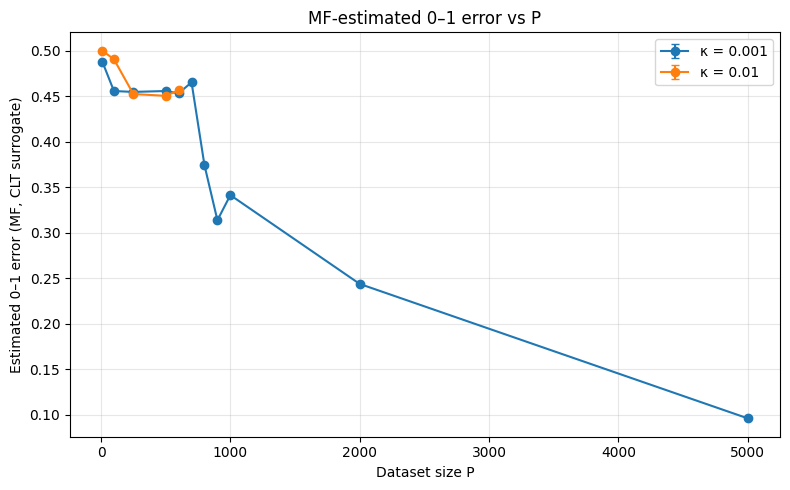

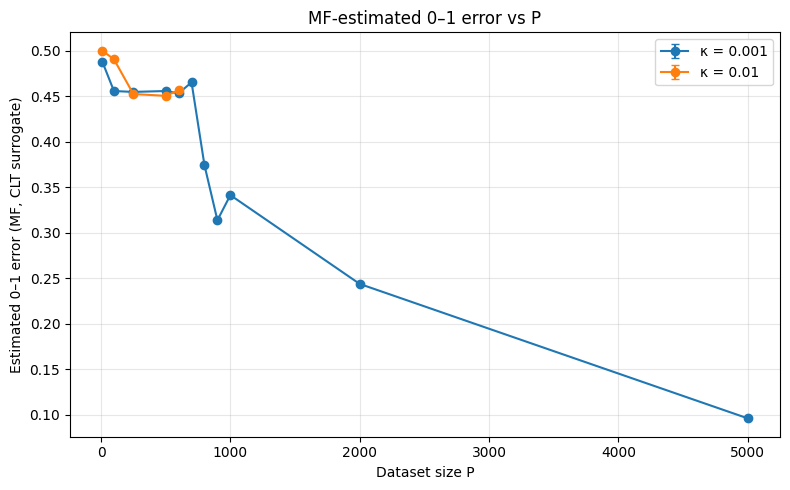

In [5]:
# === MF 0–1 error plotter (adapted for 0908_der3_nospecialsplit_finiteP_multi_simblocks_fullvar4.py) ===
import os, re, json, math, glob
from collections import defaultdict
from math import comb
import numpy as np
import matplotlib.pyplot as plt

def phi_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

# ---------- helpers to match the new training output ----------

def parse_meta_from_filename(path):
    """
    Extract kappa, P (and optionally K) from filenames like:
      quenched_parallel_xfit_<tag>_kap1.000e-03_P750_K4.json
    Returns (kappa_float|None, P_int|None, K_int|None).
    """
    fname = os.path.basename(path)
    mk = re.search(r"_kap([0-9eE\+\-\.]+)", fname)
    mp = re.search(r"_P(\d+)", fname)
    kblk = re.search(r"_K(\d+)", fname)
    try:
        kappa = float(mk.group(1)) if mk else None
        P = int(mp.group(1)) if mp else None
        K = int(kblk.group(1)) if kblk else None
        return kappa, P, K
    except Exception:
        return None, None, None

def estimate_M_noise_from_BASE(base: dict) -> int:
    """
    Reconstruct # of tracked 'noise' modes (all modes except the teacher)
    from BASE settings used by build_modes_index_varcard(…).

    Rules:
      - Include ALL combos for cardinalities c=1..card_track_max,
        except remove the teacher when c == k.
      - For c > card_track_max: include min(sample_high_per_card, C(d,c)) per degree.
    """
    if not isinstance(base, dict):
        return None
    d = int(base.get("d", 0))
    k = int(base.get("k", 0))
    card_track_max = int(base.get("card_track_max", 0))
    sample_high_per_card = int(base.get("sample_high_per_card", 0))
    if d <= 0:
        return None

    M_noise = 0
    for c in range(1, d + 1):
        nc = comb(d, c)
        if c <= card_track_max:
            add = nc
            if c == k:
                # build_modes_index_varcard drops the teacher at this cardinality
                add = max(add - 1, 0)
        else:
            add = min(sample_high_per_card, nc) if sample_high_per_card > 0 else 0
        M_noise += add
    return int(M_noise)  # excludes the teacher by construction

# ---------- core computation ----------

def estimate_err01_from_file(path, iter_index=-1, vnoise_floor=1e-16):
    """
    Estimate MF 0–1 error per file at iteration 'iter_index' (default: final).
    Uses CLT surrogate: err ≈ Φ( - mS / sqrt(V_noise) ), with
      V_noise = M_noise * (RMS_noise)^2,
    where RMS_noise is saved by the training code as sqrt(mean_A m_A^2) over A≠S.
    Returns dict or None on failure.
    """
    kappa_f, P_f, _K = parse_meta_from_filename(path)
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except Exception:
        return None

    # Fill/override from JSON when available
    summary = data.get("summary", {})
    base = summary.get("BASE", {}) or data.get("BASE", {})

    kappa = kappa_f if kappa_f is not None else summary.get("kappa", None)
    P     = P_f     if P_f     is not None else summary.get("P", None)

    if (kappa is None) or (P is None):
        return None

    # Reconstruct M_noise from BASE (preferred path for var-card tracking)
    M_noise = estimate_M_noise_from_BASE(base)

    # If BASE didn’t have var-card info, try legacy filename pattern _M(\d+)
    if M_noise in (None, 0):
        mm = re.search(r"_M(\d+)", os.path.basename(path))
        M_noise = int(mm.group(1)) if mm else None

    # As a last resort, assume 1 (keeps plotting alive, but warns)
    m_noise_source = "base" if M_noise is not None else "fallback=1"
    if M_noise is None:
        M_noise = 1

    traj = data.get("trajectories", {})
    mS_per_iter = traj.get("m_S_per_iter", None)
    noise_rms_per_iter = traj.get("m_noise_rms_per_iter", None)
    if not mS_per_iter or not noise_rms_per_iter:
        return None

    try:
        mS  = np.array(mS_per_iter[iter_index], dtype=float)       # (blocks,)
        rms = np.array(noise_rms_per_iter[iter_index], dtype=float)
    except Exception:
        return None

    good = np.isfinite(mS) & np.isfinite(rms)
    if not np.any(good):
        return None
    mS  = mS[good]
    rms = rms[good]

    # V_noise = sum_A m_A^2  =  M_noise * mean_A(m_A^2)  =  M_noise * (RMS_noise)^2
    V_noise = (float(M_noise)) * (rms ** 2)
    V_noise = np.maximum(V_noise, vnoise_floor)

    snr = mS / np.sqrt(V_noise)
    err01 = np.array([phi_cdf(-float(s)) for s in snr], dtype=float)

    return {
        "kappa": float(kappa),
        "P": int(P),
        "M_noise": int(M_noise),
        "err01_block_mean": float(err01.mean()),
        "err01_block_std": float(err01.std(ddof=0)),
        "n_blocks": int(err01.size),
        "file": path,
        "M_noise_source": m_noise_source,
    }

def aggregate_by_kappa_P(rows):
    """
    Aggregate rows with the same (kappa, P) weighting by #blocks.
    """
    groups = defaultdict(list)
    for r in rows:
        groups[(r["kappa"], r["P"])].append(r)

    agg = []
    for (kappa, P), rs in groups.items():
        weights = np.array([r["n_blocks"] for r in rs], dtype=float)
        vals    = np.array([r["err01_block_mean"] for r in rs], dtype=float)
        mean = float(np.average(vals, weights=weights))
        std_over_runs = float(np.std(vals, ddof=0))
        total_blocks = int(np.sum(weights))
        # prefer consistent M_noise; if mixed, take weighted average (informative print only)
        m_vals = np.array([r["M_noise"] for r in rs], dtype=float)
        M_noise_eff = float(np.average(m_vals, weights=weights))
        agg.append({
            "kappa": float(kappa),
            "P": int(P),
            "M_noise_eff": M_noise_eff,
            "err01_mean": mean,
            "err01_std_over_runs": std_over_runs,
            "n_runs": len(rs),
            "total_blocks": total_blocks,
        })
    return agg

def plot_err_vs_P(agg_rows, title=None):
    """
    Plot err01_mean vs P, color-coded by kappa. Returns (fig, ax).
    """
    by_kappa = defaultdict(list)
    for r in agg_rows:
        by_kappa[r["kappa"]].append(r)

    fig, ax = plt.subplots(figsize=(8, 5))
    for kappa in sorted(by_kappa.keys()):
        rows = sorted(by_kappa[kappa], key=lambda r: r["P"])
        Ps   = [r["P"] for r in rows]
        errs = [r["err01_mean"] for r in rows]
        yerr = [r["err01_std_over_runs"] for r in rows]
        label = f"κ = {kappa:g}"
        ax.errorbar(Ps, errs, yerr=yerr, capsize=3, marker="o", linestyle="-", label=label)

    ax.set_xlabel("Dataset size P")
    ax.set_ylabel("Estimated 0–1 error (MF, CLT surrogate)")
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    return fig, ax

def make_plot_from_dir(results_dir, iter_index=-1, save_png=True, png_name="mf_estimated_01_vs_P.png"):
    """
    Scan a directory for *.json produced by the training script, compute MF 0–1 error
    at the chosen iteration (default: final), aggregate by (kappa,P), and plot.
    """
    paths = glob.glob(os.path.join(results_dir, "*.json"))
    rows = []
    for p in paths:
        r = estimate_err01_from_file(p, iter_index=iter_index)
        if r is not None:
            rows.append(r)

    if not rows:
        print("No usable JSON files found (or unable to parse κ, P / read trajectories).")
        return None

    agg = aggregate_by_kappa_P(rows)

    # Console summary (nice in notebooks too)
    print("Aggregated by (κ, P):")
    for r in sorted(agg, key=lambda t: (t["kappa"], t["P"])):
        print(f"  κ={r['kappa']:g}  P={r['P']:>6d}  "
              f"err01_mean={r['err01_mean']:.4f}  runs={r['n_runs']}  "
              f"blocks={r['total_blocks']}  M_noise_eff≈{r['M_noise_eff']:.1f}")

    fig, ax = plot_err_vs_P(agg, title="MF-estimated 0–1 error vs P")

    if save_png:
        out_png = os.path.join(results_dir, png_name)
        fig.savefig(out_png, dpi=150)
        print(f"[saved plot] {out_png}")

    return {"agg": agg, "fig": fig, "ax": ax}

results_dir = "/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_8k_2000"
out = make_plot_from_dir(results_dir, iter_index=-1, save_png=False)
out["fig"]  # in a notebook



--- card2_h100_8k (/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_8k_2000) ---
  κ=0.001  P=    10  err01_mean=0.4880  mS_mean=0.0017  m_noise_rms_mean=1.1476e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   100  err01_mean=0.4557  mS_mean=0.0210  m_noise_rms_mean=3.8009e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   250  err01_mean=0.4547  mS_mean=0.0345  m_noise_rms_mean=6.1217e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   500  err01_mean=0.4557  mS_mean=0.0223  m_noise_rms_mean=4.0441e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   600  err01_mean=0.4532  mS_mean=0.0220  m_noise_rms_mean=3.7818e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   700  err01_mean=0.4652  mS_mean=0.0154  m_noise_rms_mean=3.5631e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   800  err01_mean=0.3741  mS_mean=0.0850  m_noise_rms_mean=5.3519e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   900  err01_mean=0.3137  mS_mean=

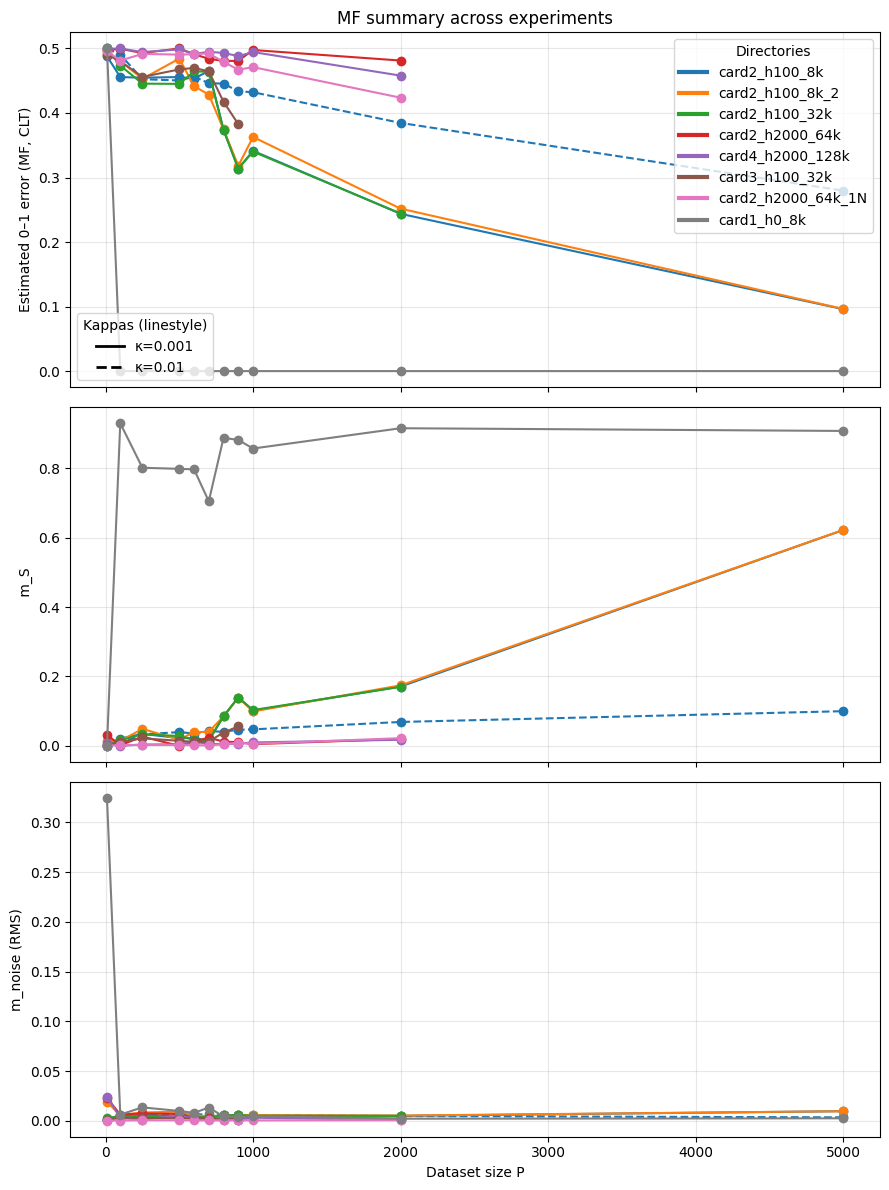

In [1]:
# === Multi-dir MF plotter: error, 1-m_S, and m_noise (RMS) ===
import os, re, json, math, glob
from collections import defaultdict
from math import comb
from typing import List, Tuple, Dict, Iterable, Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def phi_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

# ---------- helpers to match the new training output ----------

def parse_meta_from_filename(path):
    """
    Extract kappa, P (and optionally K) from filenames like:
      quenched_parallel_xfit_<tag>_kap1.000e-03_P750_K4.json
    Returns (kappa_float|None, P_int|None, K_int|None).
    """
    fname = os.path.basename(path)
    mk = re.search(r"_kap([0-9eE\+\-\.]+)", fname)
    mp = re.search(r"_P(\d+)", fname)
    kblk = re.search(r"_K(\d+)", fname)
    try:
        kappa = float(mk.group(1)) if mk else None
        P = int(mp.group(1)) if mp else None
        K = int(kblk.group(1)) if kblk else None
        return kappa, P, K
    except Exception:
        return None, None, None

def estimate_M_noise_from_BASE(base: dict) -> int:
    """
    Reconstruct # of tracked 'noise' modes (all modes except the teacher)
    from BASE settings used by build_modes_index_varcard(…).

    Rules:
      - Include ALL combos for cardinalities c=1..card_track_max,
        except remove the teacher when c == k.
      - For c > card_track_max: include min(sample_high_per_card, C(d,c)) per degree.
    """
    if not isinstance(base, dict):
        return None
    d = int(base.get("d", 0))
    k = int(base.get("k", 0))
    card_track_max = int(base.get("card_track_max", 0))
    sample_high_per_card = int(base.get("sample_high_per_card", 0))
    if d <= 0:
        return None

    M_noise = 0
    for c in range(1, d + 1):
        nc = comb(d, c)
        if c <= card_track_max:
            add = nc
            if c == k:
                add = max(add - 1, 0)  # drop teacher at this cardinality
        else:
            add = min(sample_high_per_card, nc) if sample_high_per_card > 0 else 0
        M_noise += add
    return int(M_noise)  # excludes the teacher by construction

# ---------- per-file metrics ----------

def estimate_metrics_from_file(path, iter_index=-1, vnoise_floor=1e-16):
    """
    Compute three per-file metrics at iteration 'iter_index' (default: final):
      - MF 0–1 error surrogate: err ≈ Φ( - mS / sqrt(V_noise) )
      - mS_block_mean
      - m_noise_rms_block_mean  (RMS over tracked noise modes)
    Returns dict or None on failure.
    """
    kappa_f, P_f, _K = parse_meta_from_filename(path)
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except Exception:
        return None

    summary = data.get("summary", {})
    base = summary.get("BASE", {}) or data.get("BASE", {})

    kappa = kappa_f if kappa_f is not None else summary.get("kappa", None)
    P     = P_f     if P_f     is not None else summary.get("P", None)

    if (kappa is None) or (P is None):
        return None

    # Reconstruct M_noise from BASE (preferred path for var-card tracking)
    M_noise = estimate_M_noise_from_BASE(base)

    # If BASE didn’t have var-card info, try legacy filename pattern _M(\d+)
    if M_noise in (None, 0):
        mm = re.search(r"_M(\d+)", os.path.basename(path))
        M_noise = int(mm.group(1)) if mm else None

    if M_noise is None:
        M_noise = 1  # last resort to keep plotting alive

    traj = data.get("trajectories", {})
    mS_per_iter = traj.get("m_S_per_iter", None)
    noise_rms_per_iter = traj.get("m_noise_rms_per_iter", None)
    if mS_per_iter is None or noise_rms_per_iter is None:
        return None

    try:
        mS_blocks  = np.array(mS_per_iter[iter_index], dtype=float)       # (blocks,)
        rms_blocks = np.array(noise_rms_per_iter[iter_index], dtype=float)
    except Exception:
        return None

    good = np.isfinite(mS_blocks) & np.isfinite(rms_blocks)
    if not np.any(good):
        return None
    mS_blocks  = mS_blocks[good]
    rms_blocks = rms_blocks[good]

    # V_noise = sum_A m_A^2 = M_noise * mean_A(m_A^2) = M_noise * (RMS_noise)^2
    V_noise = (float(M_noise)) * (rms_blocks ** 2)
    V_noise = np.maximum(V_noise, vnoise_floor)

    snr = mS_blocks / np.sqrt(V_noise)
    err01_blocks = np.array([phi_cdf(-float(s)) for s in snr], dtype=float)

    return {
        "kappa": float(kappa),
        "P": int(P),
        "M_noise": int(M_noise),
        "err01_block_mean": float(err01_blocks.mean()),
        "err01_block_std": float(err01_blocks.std(ddof=0)),
        "mS_block_mean": float(mS_blocks.mean()),
        "mS_block_std": float(mS_blocks.std(ddof=0)),
        "m_noise_rms_block_mean": float(rms_blocks.mean()),
        "m_noise_rms_block_std": float(rms_blocks.std(ddof=0)),
        "n_blocks": int(err01_blocks.size),
        "file": path,
    }

# ---------- aggregation ----------

def aggregate_by_kappa_P(rows):
    """
    Aggregate rows with the same (kappa, P) weighting by #blocks.
    Returns list of dicts with means and std_over_runs for all metrics.
    """
    groups = defaultdict(list)
    for r in rows:
        groups[(r["kappa"], r["P"])].append(r)

    agg = []
    for (kappa, P), rs in groups.items():
        w = np.array([r["n_blocks"] for r in rs], dtype=float)
        # Weighted means across runs
        def wavg(key): return float(np.average(np.array([r[key] for r in rs], dtype=float), weights=w))

        # Unweighted std across runs (dispersion between run means)
        def run_std(key): return float(np.std(np.array([r[key] for r in rs], dtype=float), ddof=0))

        agg.append({
            "kappa": float(kappa),
            "P": int(P),
            "n_runs": len(rs),
            "total_blocks": int(np.sum(w)),
            "M_noise_eff": float(np.average(np.array([r["M_noise"] for r in rs], dtype=float), weights=w)),
            # metrics
            "err01_mean": wavg("err01_block_mean"),
            "err01_std_over_runs": run_std("err01_block_mean"),
            "mS_mean": wavg("mS_block_mean"),
            "mS_std_over_runs": run_std("mS_block_mean"),
            "m_noise_rms_mean": wavg("m_noise_rms_block_mean"),
            "m_noise_rms_std_over_runs": run_std("m_noise_rms_block_mean"),
        })
    return agg

# ---------- plotting ----------

def _coerce_dir_label_pairs(
    dirs_and_labels: Union[Dict[str, str], Iterable[Tuple[str, str]]]
) -> List[Tuple[str, str]]:
    """
    Accept either:
      - list of (dir, label) tuples, OR
      - dict {label: dir}
    Return list[(dir, label)] preserving order where possible.
    """
    if isinstance(dirs_and_labels, dict):
        return [(v, k) for k, v in dirs_and_labels.items()]
    else:
        return list(dirs_and_labels)

def make_plots_from_dirs(
    dirs_and_labels: Union[Dict[str, str], Iterable[Tuple[str, str]]],
    iter_index: int = -1,
    save_png: bool = True,
    out_png: str = "mf_multi_summary.png",
    verbose: bool = True,
):
    """
    For each directory, scan *.json, compute metrics at 'iter_index', aggregate by (kappa,P),
    then plot three stacked subplots:
      (1) MF-estimated 0–1 error vs P
      (2) 1 - m_S vs P
      (3) m_noise (RMS) vs P

    Colors differentiate DIRECTORIES (labels); line styles differentiate KAPPAS.
    """
    pairs = _coerce_dir_label_pairs(dirs_and_labels)

    # 1) Collect & aggregate per directory
    per_dir_agg = {}
    for (results_dir, label) in pairs:
        paths = glob.glob(os.path.join(results_dir, "*.json"))
        rows = []
        for p in paths:
            r = estimate_metrics_from_file(p, iter_index=iter_index)
            if r is not None:
                rows.append(r)

        if not rows:
            if verbose:
                print(f"[warn] No usable JSON in {results_dir}")
            per_dir_agg[label] = []
            continue

        agg = aggregate_by_kappa_P(rows)
        if verbose:
            print(f"--- {label} ({results_dir}) ---")
            for r in sorted(agg, key=lambda t: (t["kappa"], t["P"])):
                print(f"  κ={r['kappa']:g}  P={r['P']:>6d}  "
                      f"err01_mean={r['err01_mean']:.4f}  "
                      f"mS_mean={r['mS_mean']:.4f}  "
                      f"m_noise_rms_mean={r['m_noise_rms_mean']:.4e}  "
                      f"runs={r['n_runs']}  blocks={r['total_blocks']}  "
                      f"M_noise_eff≈{r['M_noise_eff']:.1f}")
        per_dir_agg[label] = agg

    # 2) Build style maps: color per directory, linestyle per kappa
    # Colors: pull from current Matplotlib cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
    if not color_cycle:
        color_cycle = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
    color_map = {}
    for i, (_, label) in enumerate(pairs):
        color_map[label] = color_cycle[i % len(color_cycle)]

    # Line styles for kappas (cycle if needed)
    linestyle_choices = [
        "-", "--", ":", "-.", (0, (3,1,1,1)), (0, (5,5)), (0, (1,1)), (0, (5,1)), (0,(2,2,1,2))
    ]
    # Gather all kappas present across all directories
    kappas_all = sorted(set(round(r["kappa"], 12)
                            for agg in per_dir_agg.values() for r in agg))
    kappa_linestyle = {k: linestyle_choices[i % len(linestyle_choices)]
                       for i, k in enumerate(kappas_all)}

    # 3) Plot (3 stacked subplots)
    fig, axes = plt.subplots(3, 1, figsize=(9, 12), sharex=True)
    ax_err, ax_1mS, ax_rms = axes

    # Helper to draw one metric into an axis
    def plot_metric(ax, metric_key, ylabel, transform=None):
        for (results_dir, label) in pairs:
            agg = per_dir_agg.get(label, [])
            # Group by kappa
            by_kappa = defaultdict(list)
            for r in agg:
                by_kappa[r["kappa"]].append(r)

            for kappa in sorted(by_kappa.keys()):
                rows_k = sorted(by_kappa[kappa], key=lambda r: r["P"])
                Ps   = np.array([r["P"] for r in rows_k], dtype=int)
                vals = np.array([r[metric_key] for r in rows_k], dtype=float)
                yerr = None
                std_key = None
                if metric_key == "err01_mean":
                    std_key = "err01_std_over_runs"
                elif metric_key == "mS_mean":
                    std_key = "mS_std_over_runs"
                elif metric_key == "m_noise_rms_mean":
                    std_key = "m_noise_rms_std_over_runs"
                if std_key is not None:
                    yerr = np.array([r[std_key] for r in rows_k], dtype=float)

                if transform is not None:
                    vals = transform(vals)

                ax.errorbar(
                    Ps, vals, yerr=yerr, capsize=3,
                    marker="o", linestyle=kappa_linestyle[round(kappa,12)],
                    label=f"{label} | κ={kappa:g}",
                    color=color_map[label]
                )

        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)

    # Top: MF-estimated 0–1 error
    plot_metric(ax_err, "err01_mean", "Estimated 0–1 error (MF, CLT)")

    # Middle: 1 - m_S
    plot_metric(ax_1mS, "mS_mean", " m_S", transform=lambda v:  v)

    # Bottom: m_noise (RMS)
    plot_metric(ax_rms, "m_noise_rms_mean", "m_noise (RMS)")

    # X label and titles
    ax_rms.set_xlabel("Dataset size P")
    ax_err.set_title("MF summary across experiments")

    # 4) Build two legends: colors = directories, linestyles = kappas
    dir_handles = [Line2D([0], [0], color=color_map[label], lw=3, label=label)
                   for (_, label) in pairs]
    kappa_handles = [Line2D([0], [0], color="black",
                            linestyle=kappa_linestyle[k], lw=2, label=f"κ={k:g}")
                     for k in kappas_all]

    # Put legends on the top subplot (avoid duplicates)
    leg1 = ax_err.legend(handles=dir_handles, title="Directories", loc="upper right")
    ax_err.add_artist(leg1)
    ax_err.legend(handles=kappa_handles, title="Kappas (linestyle)", loc="lower left")

    fig.tight_layout()

    if save_png:
        fig.savefig(out_png, dpi=150)
        if verbose:
            print(f"[saved plot] {out_png}")

    return {
        "per_dir_agg": per_dir_agg,
        "fig": fig,
        "axes": axes,
        "color_map": color_map,
        "kappa_linestyle": kappa_linestyle,
    }

# ---------- example usage ----------
if __name__ == "__main__":
    # Provide either a list of (directory, label) tuples...
    pairs = [
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_8k_2000", "card2_h100_8k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_8k_2000_2", "card2_h100_8k_2"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_32k_2000", "card2_h100_32k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h2000_50k_1000_2", "card2_h2000_64k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card4_h2000_64k_1200_2", "card4_h2000_128k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card3_h100_32k_2000", "card3_h100_32k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h2000_64k_1200_1N_3", "card2_h2000_64k_1N"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card1_h0_8k_2000", "card1_h0_8k"),

        # ("/path/to/other/results", "my_other_run"),
    ]
    # ...or a dict mapping label -> directory:
    # pairs = {"card2_h100_8k_2000": "/home/goring/.../card2_h100_8k_2000",
    #          "my_other_run": "/path/to/other/results"}

    out = make_plots_from_dirs(pairs, iter_index=-1, save_png=False)
    # In a notebook: out["fig"]


--- card2_h2000_64k (/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h2000_50k_1000_2) ---
  κ=0.001  P=    10  err01_mean=0.4973  mS_mean=0.0319  m_noise_rms_mean=2.3092e-02  runs=1  blocks=1  M_noise_eff≈40651.0
  κ=0.001  P=   100  err01_mean=0.4995  mS_mean=0.0015  m_noise_rms_mean=6.1694e-03  runs=1  blocks=1  M_noise_eff≈40651.0
  κ=0.001  P=   250  err01_mean=0.4930  mS_mean=0.0265  m_noise_rms_mean=7.4612e-03  runs=1  blocks=1  M_noise_eff≈40651.0
  κ=0.001  P=   500  err01_mean=0.5000  mS_mean=0.0000  m_noise_rms_mean=6.8491e-03  runs=1  blocks=1  M_noise_eff≈40651.0
  κ=0.001  P=   600  err01_mean=0.4912  mS_mean=0.0130  m_noise_rms_mean=2.9104e-03  runs=1  blocks=1  M_noise_eff≈40651.0
  κ=0.001  P=   700  err01_mean=0.4839  mS_mean=0.0235  m_noise_rms_mean=2.8938e-03  runs=1  blocks=1  M_noise_eff≈40651.0
  κ=0.001  P=   800  err01_mean=0.4807  mS_mean=0.0122  m_noise_rms_mean=1.2502e-03  runs=1  blocks=1  M_noise_eff≈40651.0
  κ=0.001  P=   900  err01_mean=0.4

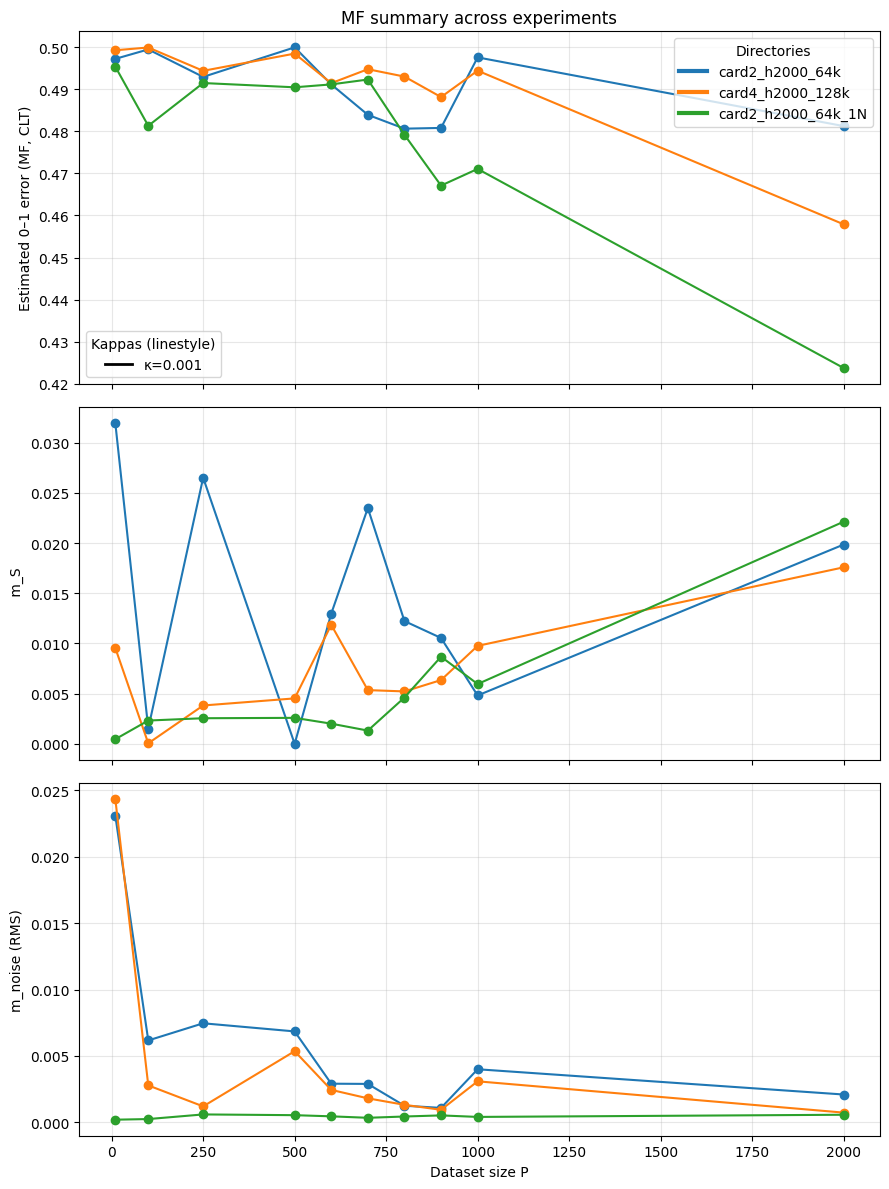

In [104]:
if __name__ == "__main__":
    # Provide either a list of (directory, label) tuples...
    pairs = [
        
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h2000_50k_1000_2", "card2_h2000_64k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card4_h2000_64k_1200_2", "card4_h2000_128k"),
        
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h2000_64k_1200_1N_3", "card2_h2000_64k_1N"),

        # ("/path/to/other/results", "my_other_run"),
    ]
    # ...or a dict mapping label -> directory:
    # pairs = {"card2_h100_8k_2000": "/home/goring/.../card2_h100_8k_2000",
    #          "my_other_run": "/path/to/other/results"}

    out = make_plots_from_dirs(pairs, iter_index=-1, save_png=False)
    # In a notebook: out["fig"]


--- card2_h100_8k (/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_8k_2000) ---
  κ=0.001  P=    10  err01_mean=0.4880  mS_mean=0.0017  m_noise_rms_mean=1.1476e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   100  err01_mean=0.4557  mS_mean=0.0210  m_noise_rms_mean=3.8009e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   250  err01_mean=0.4547  mS_mean=0.0345  m_noise_rms_mean=6.1217e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   500  err01_mean=0.4557  mS_mean=0.0223  m_noise_rms_mean=4.0441e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   600  err01_mean=0.4532  mS_mean=0.0220  m_noise_rms_mean=3.7818e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   700  err01_mean=0.4652  mS_mean=0.0154  m_noise_rms_mean=3.5631e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   800  err01_mean=0.3741  mS_mean=0.0850  m_noise_rms_mean=5.3519e-03  runs=1  blocks=1  M_noise_eff≈2451.0
  κ=0.001  P=   900  err01_mean=0.3137  mS_mean=

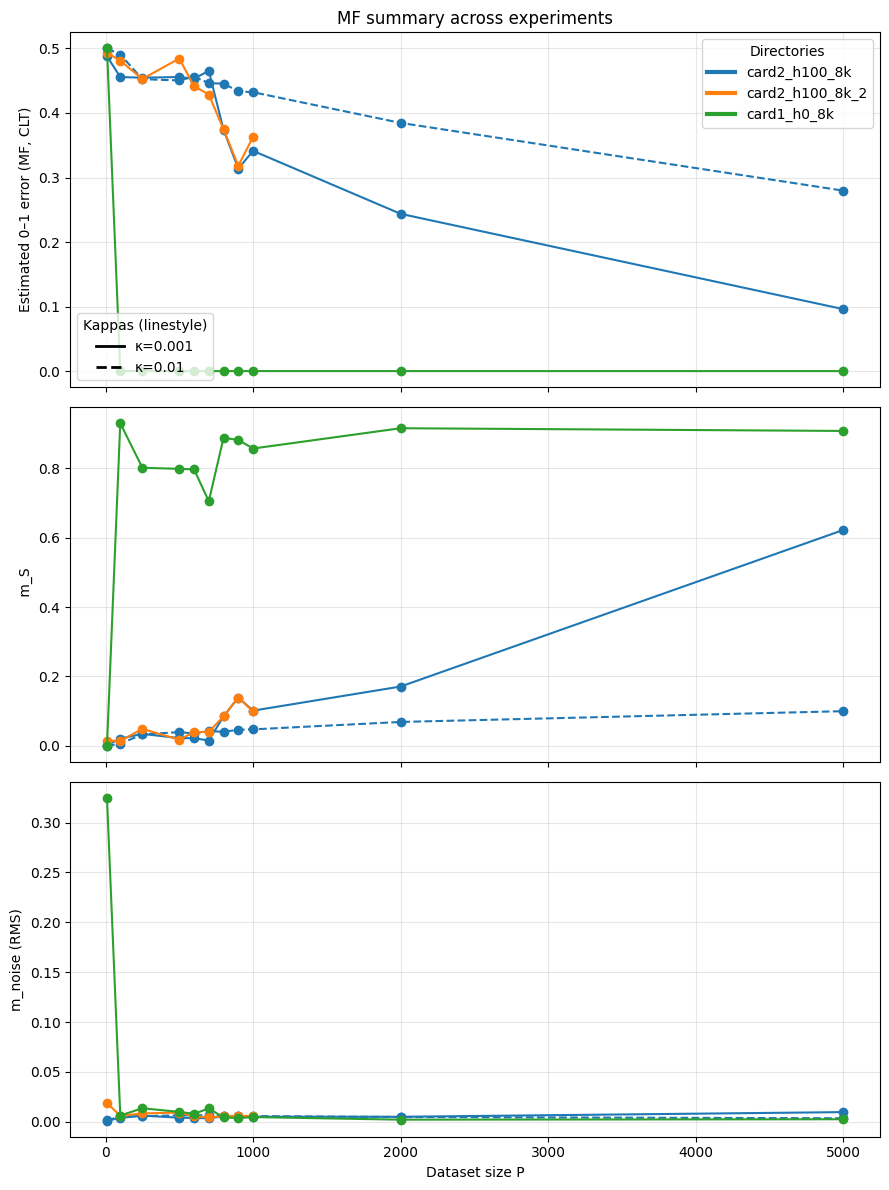

In [98]:

# ---------- example usage ----------
if __name__ == "__main__":
    # Provide either a list of (directory, label) tuples...
    pairs = [
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_8k_2000", "card2_h100_8k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card2_h100_8k_2000_2", "card2_h100_8k_2"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results2/card1_h0_8k_2000", "card1_h0_8k"),

        # ("/path/to/other/results", "my_other_run"),
    ]
    # ...or a dict mapping label -> directory:
    # pairs = {"card2_h100_8k_2000": "/home/goring/.../card2_h100_8k_2000",
    #          "my_other_run": "/path/to/other/results"}

    out = make_plots_from_dirs(pairs, iter_index=-1, save_png=False)
    # In a notebook: out["fig"]


--- card2_h50_64k (/home/goring/mean_field_langevin/MCMC_finiteP/results3/c2_h50_64k_2000_2e-3_2) ---
  κ=0.001  P=    10  err01_mean=0.4992  mS_mean=0.0061  m_noise_rms_mean=8.2463e-02  runs=1  blocks=1  M_noise_eff≈1401.0
  κ=0.001  P=   100  err01_mean=0.4970  mS_mean=0.0698  m_noise_rms_mean=2.5192e-01  runs=1  blocks=1  M_noise_eff≈1401.0
  κ=0.001  P=   250  err01_mean=0.4953  mS_mean=0.1507  m_noise_rms_mean=3.4415e-01  runs=1  blocks=1  M_noise_eff≈1401.0
  κ=0.001  P=   500  err01_mean=0.4924  mS_mean=0.2911  m_noise_rms_mean=4.0701e-01  runs=1  blocks=1  M_noise_eff≈1401.0
  κ=0.001  P=   700  err01_mean=0.4907  mS_mean=0.3677  m_noise_rms_mean=4.1951e-01  runs=1  blocks=1  M_noise_eff≈1401.0
  κ=0.001  P=   900  err01_mean=0.4893  mS_mean=0.4233  m_noise_rms_mean=4.1988e-01  runs=1  blocks=1  M_noise_eff≈1401.0
  κ=0.001  P=  1000  err01_mean=0.4887  mS_mean=0.4447  m_noise_rms_mean=4.1924e-01  runs=1  blocks=1  M_noise_eff≈1401.0
[warn] No usable JSON in /home/goring/mean_f

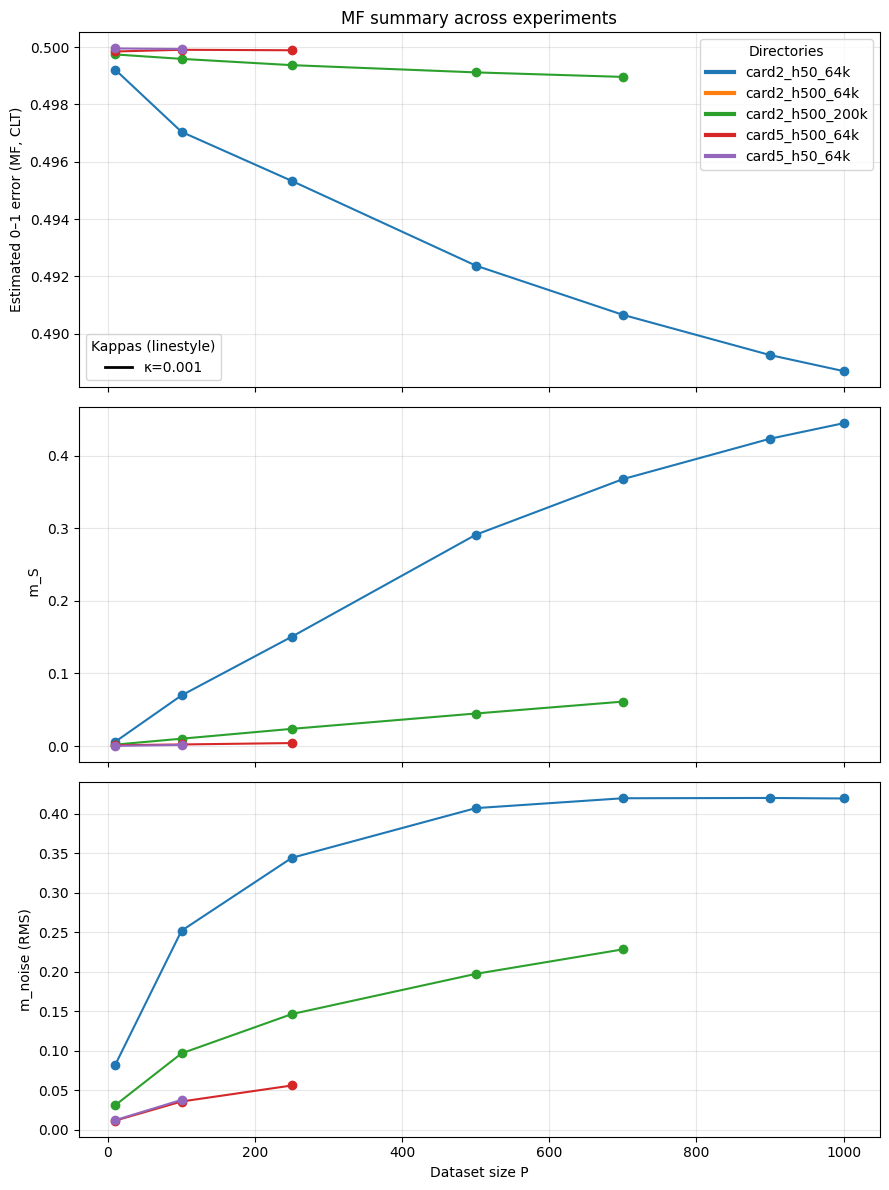

In [5]:

# ---------- example usage ----------
if __name__ == "__main__":
    # Provide either a list of (directory, label) tuples...
    pairs = [
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results3/c2_h50_64k_2000_2e-3_2", "card2_h50_64k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results3/c2_h500_65k_2000_2e-3_2", "card2_h500_64k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results3/c2_h500_200k_1000", "card2_h500_200k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results3/c5_h500_65k_1000", "card5_h500_64k"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results3/c5_h50_65k", "card5_h50_64k"),
        

        # ("/path/to/other/results", "my_other_run"),
    ]
    # ...or a dict mapping label -> directory:
    # pairs = {"card2_h100_8k_2000": "/home/goring/.../card2_h100_8k_2000",
    #          "my_other_run": "/path/to/other/results"}

    out = make_plots_from_dirs(pairs, iter_index=-1, save_png=False)
    # In a notebook: out["fig"]


--- card3_h500_enum (/home/goring/mean_field_langevin/MCMC_finiteP/results5/c3_500_enumerate) ---
  κ=0.001  P=    10  err01=0.4863  m_S=0.0010  MSE=4.9983e-01  runs=1
  κ=0.001  P=   100  err01=0.4632  m_S=0.0082  MSE=4.9974e-01  runs=1
  κ=0.001  P=   500  err01=0.4494  m_S=0.0201  MSE=5.0507e-01  runs=1
  κ=0.001  P=  1000  err01=0.4494  m_S=0.0337  MSE=5.3690e-01  runs=1
  κ=0.001  P=  3000  err01=0.2178  m_S=0.0877  MSE=4.2878e-01  runs=1
  κ=0.001  P=  5000  err01=0.1695  m_S=0.1247  MSE=4.0009e-01  runs=1
  κ=0.001  P= 10000  err01=0.3204  m_S=0.2006  MSE=5.0443e-01  runs=1
--- card3_h8192_probe (/home/goring/mean_field_langevin/MCMC_finiteP/results5/c3_h8192_probe) ---
  κ=0.001  P=    10  err01=0.4937  m_S=0.0006  MSE=5.0089e-01  runs=1
  κ=0.001  P=   100  err01=0.3552  m_S=0.0340  MSE=4.7495e-01  runs=1
  κ=0.001  P=   500  err01=0.4300  m_S=0.0184  MSE=4.9264e-01  runs=1
  κ=0.001  P=  1000  err01=0.3724  m_S=0.0405  MSE=4.7580e-01  runs=1
  κ=0.001  P=  3000  err01=0.2766 

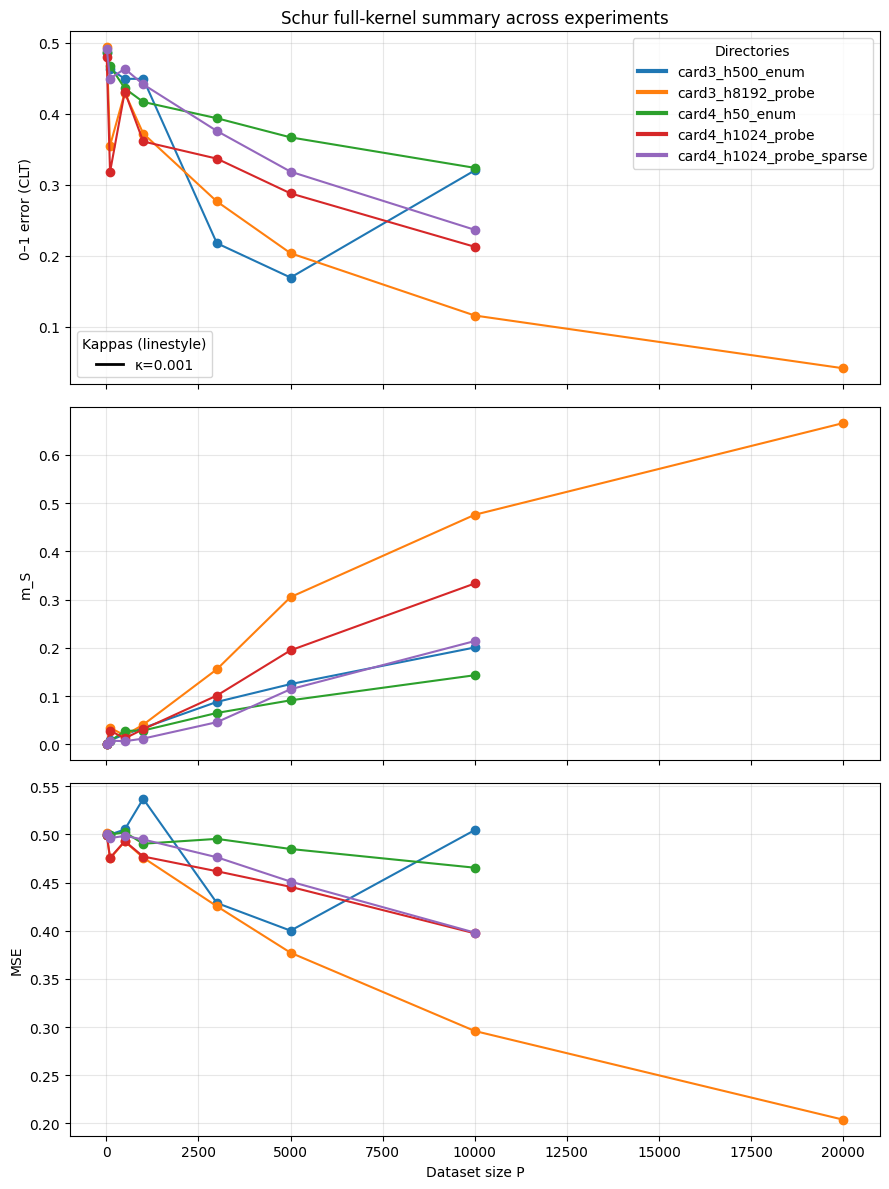

In [1]:
# === Multi-dir plotter for schur_fullkernel runs: m_S, MSE, and 0–1 error (CLT) ===
import os, re, json, glob
from collections import defaultdict
from typing import List, Tuple, Dict, Iterable, Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---------- helpers ----------

def parse_meta_from_filename(path):
    """
    Extract kappa, P from filenames like:
      schur_fullkernel_<tag>_kap1.000e-03_P750_M123.json
    Returns (kappa_float|None, P_int|None).
    """
    fname = os.path.basename(path)
    mk = re.search(r"_kap([0-9eE\+\-\.]+)", fname)
    mp = re.search(r"_P(\d+)", fname)
    try:
        kappa = float(mk.group(1)) if mk else None
        P = int(mp.group(1)) if mp else None
        return kappa, P
    except Exception:
        return None, None

def _coerce_dir_label_pairs(
    dirs_and_labels: Union[Dict[str, str], Iterable[Tuple[str, str]]]
) -> List[Tuple[str, str]]:
    """
    Accept either:
      - list of (dir, label) tuples, OR
      - dict {label: dir}
    Return list[(dir, label)] preserving order where possible.
    """
    if isinstance(dirs_and_labels, dict):
        return [(v, k) for k, v in dirs_and_labels.items()]
    else:
        return list(dirs_and_labels)

# ---------- per-file read: take values directly from file ----------

def read_last_metrics_from_file(path):
    """
    Open a schur_fullkernel JSON and read:
      - kappa, P
      - mS_last, mse_last, err01_clt_last
    Prefers summary.m*_last; falls back to traj arrays' last entries.
    Skips index files (those that have a top-level 'runs' list).
    Returns dict or None.
    """
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except Exception:
        return None

    # Skip sweep index files
    if isinstance(data, dict) and "runs" in data and "grid" in data:
        return None

    summ = data.get("summary", {}) if isinstance(data, dict) else {}
    traj = data.get("traj", {}) if isinstance(data, dict) else {}

    kappa_f, P_f = parse_meta_from_filename(path)
    kappa = summ.get("kappa", kappa_f)
    P = summ.get("P", P_f)

    if kappa is None or P is None:
        return None

    # Prefer summary.*_last
    mS = summ.get("mS_last", None)
    mse = summ.get("mse_last", None)
    err01 = summ.get("err01_clt_last", None)

    # Fallback to traj arrays
    if mS is None and isinstance(traj.get("mS"), list) and len(traj["mS"]) > 0:
        mS = float(traj["mS"][-1])
    if mse is None and isinstance(traj.get("mse"), list) and len(traj["mse"]) > 0:
        mse = float(traj["mse"][-1])
    if err01 is None and isinstance(traj.get("err01_clt"), list) and len(traj["err01_clt"]) > 0:
        err01 = float(traj["err01_clt"][-1])

    if (mS is None) or (mse is None) or (err01 is None):
        return None

    return {
        "kappa": float(kappa),
        "P": int(P),
        "mS_last": float(mS),
        "mse_last": float(mse),
        "err01_last": float(err01),
        "file": path,
    }

# ---------- aggregation over runs with same (kappa, P) ----------

def aggregate_by_kappa_P(rows):
    """
    Aggregate rows with the same (kappa, P).
    Computes simple mean across files (runs) and std across runs.
    """
    groups = defaultdict(list)
    for r in rows:
        groups[(r["kappa"], r["P"])].append(r)

    agg = []
    for (kappa, P), rs in groups.items():
        def mean(key): return float(np.mean([r[key] for r in rs], dtype=float))
        def std(key):  return float(np.std([r[key] for r in rs], dtype=float))  # population std

        agg.append({
            "kappa": float(kappa),
            "P": int(P),
            "n_runs": len(rs),
            # metrics
            "err01_mean": mean("err01_last"),
            "err01_std_over_runs": std("err01_last"),
            "mS_mean": mean("mS_last"),
            "mS_std_over_runs": std("mS_last"),
            "mse_mean": mean("mse_last"),
            "mse_std_over_runs": std("mse_last"),
        })
    return agg

# ---------- plotting ----------

def make_plots_from_dirs(
    dirs_and_labels: Union[Dict[str, str], Iterable[Tuple[str, str]]],
    *,
    save_png: bool = True,
    out_png: str = "schur_fullkernel_multi_summary.png",
    verbose: bool = True,
):
    """
    For each directory, scan *.json, read final m_S, MSE, and CLT 0–1 error, aggregate by (kappa,P),
    then draw three stacked subplots:
      (1) 0–1 error (CLT) vs P
      (2) m_S vs P
      (3) MSE vs P

    Colors differentiate DIRECTORIES (labels); line styles differentiate KAPPAS.
    """
    pairs = _coerce_dir_label_pairs(dirs_and_labels)

    # 1) Collect & aggregate per directory
    per_dir_agg = {}
    for (results_dir, label) in pairs:
        paths = glob.glob(os.path.join(results_dir, "*.json"))
        rows = []
        for p in paths:
            r = read_last_metrics_from_file(p)
            if r is not None:
                rows.append(r)

        if not rows:
            if verbose:
                print(f"[warn] No usable schur_fullkernel JSON in {results_dir}")
            per_dir_agg[label] = []
            continue

        agg = aggregate_by_kappa_P(rows)
        if verbose:
            print(f"--- {label} ({results_dir}) ---")
            for r in sorted(agg, key=lambda t: (t["kappa"], t["P"])):
                print(f"  κ={r['kappa']:g}  P={r['P']:>6d}  "
                      f"err01={r['err01_mean']:.4f}  "
                      f"m_S={r['mS_mean']:.4f}  "
                      f"MSE={r['mse_mean']:.4e}  "
                      f"runs={r['n_runs']}")
        per_dir_agg[label] = agg

    # 2) Style maps: color per directory, linestyle per kappa
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', [])
    if not color_cycle:
        color_cycle = [f"C{i}" for i in range(10)]
    color_map = {label: color_cycle[i % len(color_cycle)] for i, (_, label) in enumerate(pairs)}

    linestyle_choices = [
        "-", "--", ":", "-.", (0, (3,1,1,1)), (0, (5,5)), (0, (1,1)), (0, (5,1)), (0,(2,2,1,2))
    ]
    kappas_all = sorted(set(round(r["kappa"], 12)
                            for agg in per_dir_agg.values() for r in agg))
    kappa_linestyle = {k: linestyle_choices[i % len(linestyle_choices)]
                       for i, k in enumerate(kappas_all)}

    # 3) Plot
    fig, axes = plt.subplots(3, 1, figsize=(9, 12), sharex=True)
    ax_err, ax_mS, ax_mse = axes

    def plot_metric(ax, metric_key, ylabel):
        for (results_dir, label) in pairs:
            agg = per_dir_agg.get(label, [])
            # Group by kappa
            by_kappa = defaultdict(list)
            for r in agg:
                by_kappa[r["kappa"]].append(r)

            for kappa in sorted(by_kappa.keys()):
                rows_k = sorted(by_kappa[kappa], key=lambda r: r["P"])
                Ps   = np.array([r["P"] for r in rows_k], dtype=int)
                vals = np.array([r[metric_key] for r in rows_k], dtype=float)

                std_map = {
                    "err01_mean": "err01_std_over_runs",
                    "mS_mean": "mS_std_over_runs",
                    "mse_mean": "mse_std_over_runs",
                }
                yerr = np.array([r[std_map[metric_key]] for r in rows_k], dtype=float)

                ax.errorbar(
                    Ps, vals, yerr=yerr, capsize=3,
                    marker="o", linestyle=kappa_linestyle[round(kappa,12)],
                    label=f"{label} | κ={kappa:g}",
                    color=color_map[label]
                )

        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)

    # Top: 0–1 error (CLT)
    plot_metric(ax_err, "err01_mean", "0–1 error (CLT)")

    # Middle: m_S
    plot_metric(ax_mS, "mS_mean", "m_S")

    # Bottom: MSE
    plot_metric(ax_mse, "mse_mean", "MSE")

    # X label and title
    ax_mse.set_xlabel("Dataset size P")
    ax_err.set_title("Schur full-kernel summary across experiments")

    # 4) Legends: colors = directories, linestyles = kappas
    dir_handles = [Line2D([0], [0], color=color_map[label], lw=3, label=label)
                   for (_, label) in pairs]
    kappa_handles = [Line2D([0], [0], color="black",
                            linestyle=kappa_linestyle[k], lw=2, label=f"κ={k:g}")
                     for k in kappas_all]

    leg1 = ax_err.legend(handles=dir_handles, title="Directories", loc="upper right")
    ax_err.add_artist(leg1)
    ax_err.legend(handles=kappa_handles, title="Kappas (linestyle)", loc="lower left")

    fig.tight_layout()

    if save_png:
        fig.savefig(out_png, dpi=150)
        if verbose:
            print(f"[saved plot] {out_png}")

    return {
        "per_dir_agg": per_dir_agg,
        "fig": fig,
        "axes": axes,
        "color_map": color_map,
        "kappa_linestyle": kappa_linestyle,
    }

# ---------- example usage ----------
if __name__ == "__main__":
    pairs = [
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results5/c3_500_enumerate", "card3_h500_enum"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results5/c3_h8192_probe", "card3_h8192_probe"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results5/c4_50_enumerate", "card4_h50_enum"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results5/c4_1024_probe", "card4_h1024_probe"),
        ("/home/goring/mean_field_langevin/MCMC_finiteP/results5/c4_1024_probe_sparse"  , "card4_h1024_probe_sparse")
        # add other result folders here...
    ]
    out = make_plots_from_dirs(pairs, save_png=False)
    # In a notebook: display with `out["fig"]`


--- card3_h500_enum (/home/goring/mean_field_langevin/MCMC_finiteP/resutls_mf1) ---
  κ=0.0005  P=    10  err01=0.4429  m_S=0.0237  MSE=9.8043e-01  runs=1
  κ=0.0005  P=   100  err01=0.4418  m_S=0.0210  MSE=9.7903e-01  runs=1
  κ=0.0005  P=   250  err01=0.2562  m_S=0.0257  MSE=9.5082e-01  runs=1
  κ=0.0005  P=   500  err01=0.2239  m_S=0.0269  MSE=9.4826e-01  runs=1
  κ=0.0005  P=  1000  err01=0.2603  m_S=0.0328  MSE=9.3815e-01  runs=1
  κ=0.0005  P=  2500  err01=0.1261  m_S=0.0396  MSE=9.2362e-01  runs=1
  κ=0.001  P=    10  err01=0.4394  m_S=0.0252  MSE=9.7750e-01  runs=1
  κ=0.001  P=   100  err01=0.0733  m_S=0.1025  MSE=8.1055e-01  runs=1
  κ=0.001  P=   250  err01=0.0129  m_S=0.1160  MSE=7.8424e-01  runs=1
  κ=0.001  P=   500  err01=0.0000  m_S=0.1250  MSE=7.6649e-01  runs=1
  κ=0.001  P=  1000  err01=0.0000  m_S=0.1289  MSE=7.5957e-01  runs=1
  κ=0.001  P=  2500  err01=0.0003  m_S=0.1328  MSE=7.5347e-01  runs=1
  κ=0.005  P=    10  err01=0.4748  m_S=0.0087  MSE=1.0017e+00  runs=1


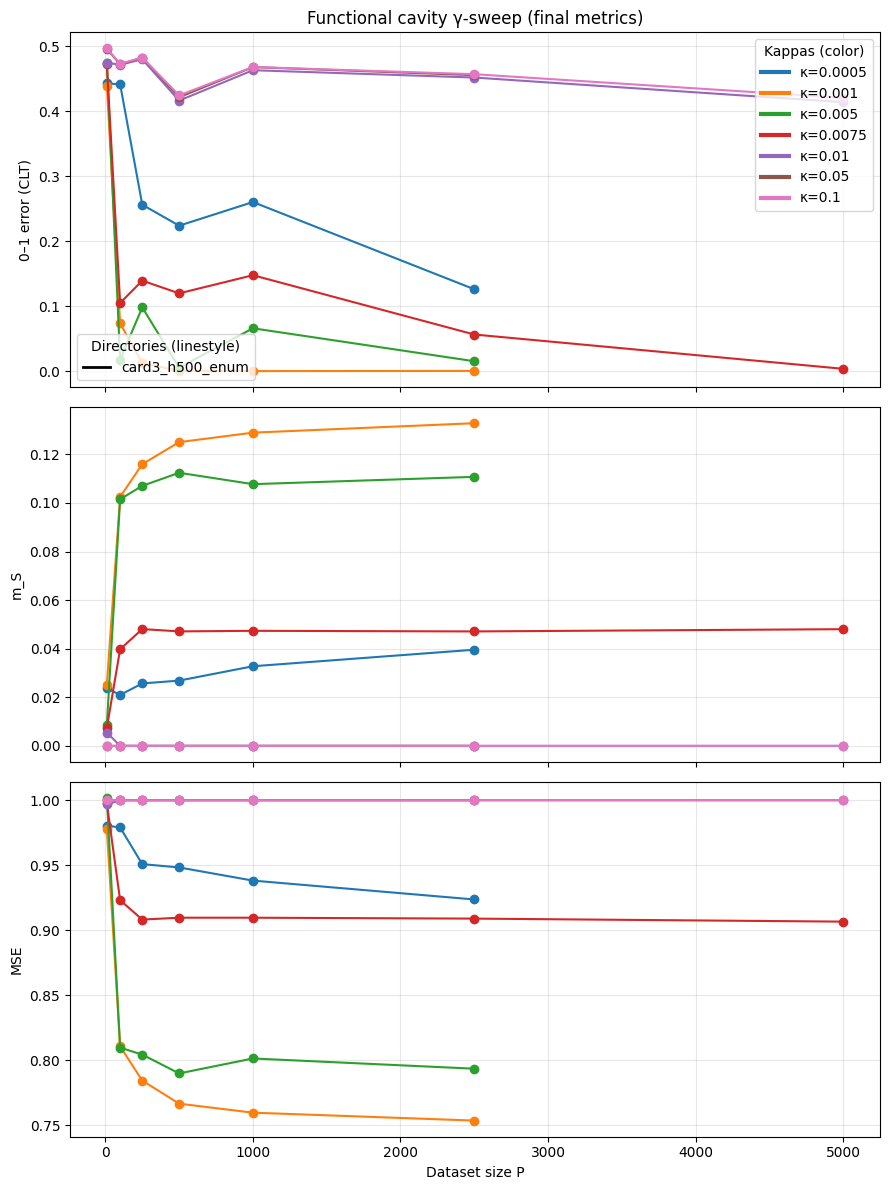

In [5]:
def make_plots_from_dirs(
    dirs_and_labels: Union[Dict[str, str], Iterable[Tuple[str, str]]],
    *,
    save_png: bool = True,
    out_png: str = "cavity_or_schur_multi_summary.png",
    verbose: bool = True,
    title: Optional[str] = None,
):
    """
    Colors differentiate KAPPAS; line styles differentiate DIRECTORIES.
    Works with both schur_fullkernel_* and cavity_func_gamma_* JSONs.
    """
    pairs = _coerce_dir_label_pairs(dirs_and_labels)

    # 1) Collect & aggregate per directory
    per_dir_agg = {}
    for (results_dir, label) in pairs:
        paths = glob.glob(os.path.join(results_dir, "*.json"))
        rows = []
        for p in paths:
            r = read_last_metrics_from_file(p)
            if r is not None:
                rows.append(r)

        if not rows:
            if verbose:
                print(f"[warn] No usable result JSONs in {results_dir}")
            per_dir_agg[label] = []
            continue

        agg = aggregate_by_kappa_P(rows)
        if verbose:
            print(f"--- {label} ({results_dir}) ---")
            for r in sorted(agg, key=lambda t: (t["kappa"], t["P"])):
                print(f"  κ={r['kappa']:g}  P={r['P']:>6d}  "
                      f"err01={r['err01_mean']:.4f}  "
                      f"m_S={r['mS_mean']:.4f}  "
                      f"MSE={r['mse_mean']:.4e}  "
                      f"runs={r['n_runs']}")
        per_dir_agg[label] = agg

    # 2) Style maps: COLOR per κ, LINESTYLE per directory
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', []) or [f"C{i}" for i in range(10)]
    kappas_all = sorted(set(round(r["kappa"], 12) for agg in per_dir_agg.values() for r in agg))
    kappa_color = {k: color_cycle[i % len(color_cycle)] for i, k in enumerate(kappas_all)}

    linestyle_choices = [
        "-", "--", ":", "-.", (0, (3,1,1,1)), (0, (5,5)), (0, (1,1)), (0, (5,1)), (0,(2,2,1,2))
    ]
    dir_linestyle = {label: linestyle_choices[i % len(linestyle_choices)]
                     for i, (_, label) in enumerate(pairs)}

    # 3) Plot
    fig, axes = plt.subplots(3, 1, figsize=(9, 12), sharex=True)
    ax_err, ax_mS, ax_mse = axes

    def plot_metric(ax, metric_key, ylabel):
        for (results_dir, label) in pairs:
            agg = per_dir_agg.get(label, [])
            # Group by kappa
            by_kappa = defaultdict(list)
            for r in agg:
                by_kappa[r["kappa"]].append(r)

            for kappa in sorted(by_kappa.keys()):
                rows_k = sorted(by_kappa[kappa], key=lambda r: r["P"])
                Ps   = np.array([r["P"] for r in rows_k], dtype=int)
                vals = np.array([r[metric_key] for r in rows_k], dtype=float)

                std_map = {
                    "err01_mean": "err01_std_over_runs",
                    "mS_mean": "mS_std_over_runs",
                    "mse_mean": "mse_std_over_runs",
                }
                yerr = np.array([r[std_map[metric_key]] for r in rows_k], dtype=float)

                ax.errorbar(
                    Ps, vals, yerr=yerr, capsize=3,
                    marker="o",
                    linestyle=dir_linestyle[label],           # directory → linestyle
                    color=kappa_color[round(kappa,12)],       # kappa → color
                )

        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)

    # Top: 0–1 error (CLT)
    plot_metric(ax_err, "err01_mean", "0–1 error (CLT)")
    # Middle: m_S
    plot_metric(ax_mS, "mS_mean", "m_S")
    # Bottom: MSE
    plot_metric(ax_mse, "mse_mean", "MSE")

    # X label and title
    ax_mse.set_xlabel("Dataset size P")
    ax_err.set_title(title or "Cavity/Schur summary across experiments")

    # 4) Legends: colors = kappas, linestyles = directories
    kappa_handles = [Line2D([0], [0], color=kappa_color[k], lw=3, label=f"κ={k:g}")
                     for k in kappas_all]
    dir_handles = [Line2D([0], [0], color="black", linestyle=dir_linestyle[label], lw=2, label=label)
                   for (_, label) in pairs]

    leg1 = ax_err.legend(handles=kappa_handles, title="Kappas (color)", loc="upper right")
    ax_err.add_artist(leg1)
    ax_err.legend(handles=dir_handles, title="Directories (linestyle)", loc="lower left")

    fig.tight_layout()

    if save_png:
        fig.savefig(out_png, dpi=150)
        if verbose:
            print(f"[saved plot] {out_png}")

    return {
        "per_dir_agg": per_dir_agg,
        "fig": fig,
        "axes": axes,
        "kappa_color": kappa_color,
        "dir_linestyle": dir_linestyle,
    }


# ---------- example usage ----------
if __name__ == "__main__":
    pairs = [
        ("/home/goring/mean_field_langevin/MCMC_finiteP/resutls_mf1", "card3_h500_enum"),
        # add other result folders here...
    ]
    out = make_plots_from_dirs(pairs, save_png=False,
                               title="Functional cavity γ-sweep (final metrics)")
    # In a notebook: display with `out["fig"]`


--- card3_h500_enum (/home/goring/mean_field_langevin/MCMC_finiteP/resutls_mf1/d40_k2_1) ---
  κ=0.001  P=    10  err01=0.4973  m_S=0.0008  MSE=1.0141e+00  runs=1
  κ=0.001  P=   100  err01=0.4634  m_S=0.0171  MSE=1.0008e+00  runs=1
  κ=0.001  P=   500  err01=0.0348  m_S=0.1085  MSE=7.9832e-01  runs=1
  κ=0.001  P=  1000  err01=0.0000  m_S=0.1150  MSE=7.8400e-01  runs=1


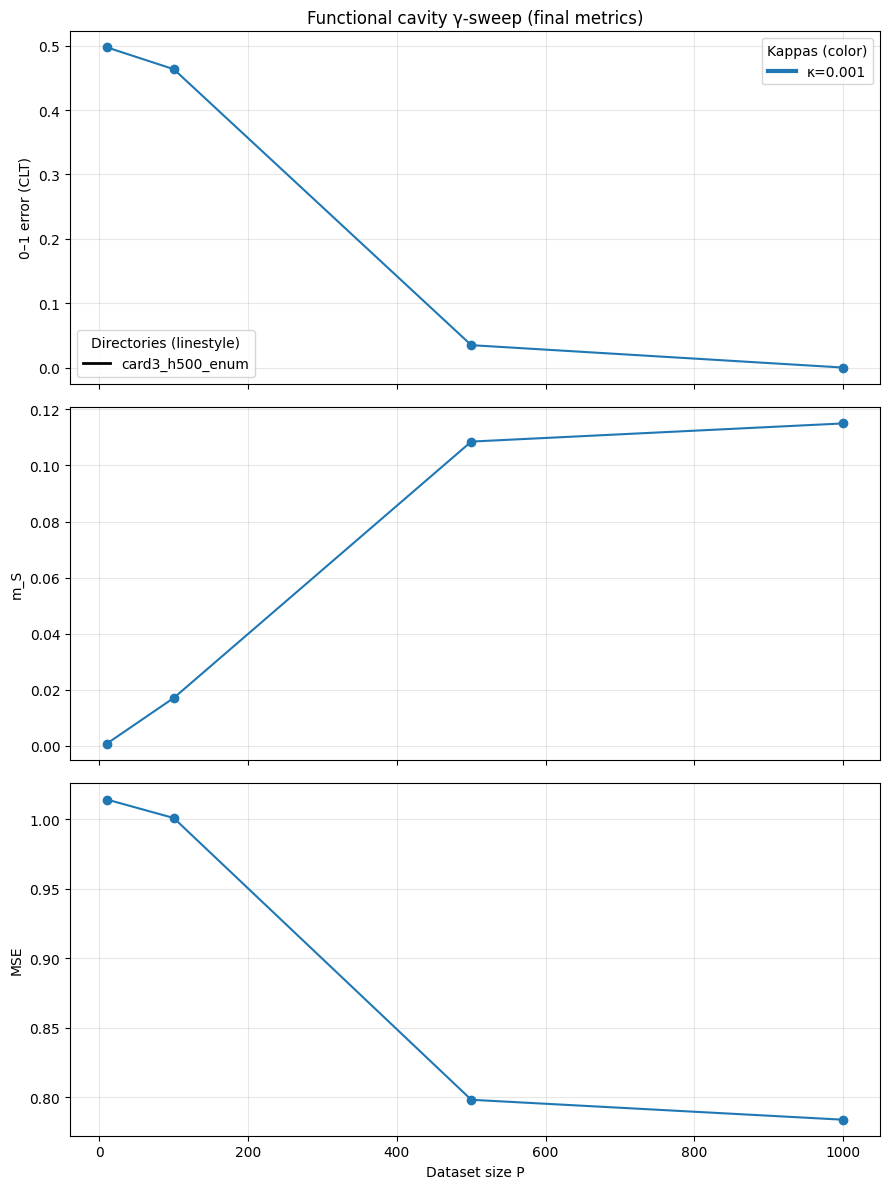

In [8]:
# ---------- example usage ----------
if __name__ == "__main__":
    pairs = [
        ("/home/goring/mean_field_langevin/MCMC_finiteP/resutls_mf1/d40_k2_1", "card3_h500_enum"),
        # add other result folders here...
    ]
    out = make_plots_from_dirs(pairs, save_png=False,
                               title="Functional cavity γ-sweep (final metrics)")
    # In a notebook: display with `out["fig"]`


--- composite_runs (/home/goring/mean_field_langevin/MCMC_composite/results/2608__d35_k4_1) ---
  γ=0  κ=0.005  P=    10  MSE=2.9378793239593506  m_S=0.00013594924530480057  χ_AA=207.85711669921875  runs(mse/mS/chi)=1/1/1
  γ=0  κ=0.005  P=   100  MSE=1.300107479095459  m_S=3.917153208021773e-06  χ_AA=164.7622833251953  runs(mse/mS/chi)=1/1/1
  γ=0  κ=0.005  P=   500  MSE=1.316137433052063  m_S=0.0009146747761406004  χ_AA=84.97506713867188  runs(mse/mS/chi)=1/1/1
  γ=0  κ=0.005  P=  1000  MSE=1.0128253698349  m_S=0.011989801190793514  χ_AA=103.79285430908203  runs(mse/mS/chi)=1/1/1
  γ=0  κ=0.005  P=  5000  MSE=0.7733327746391296  m_S=0.019025787711143494  χ_AA=141.14749145507812  runs(mse/mS/chi)=1/1/1
  γ=0  κ=0.005  P=  7500  MSE=0.8397819995880127  m_S=0.008696110919117928  χ_AA=98.9569091796875  runs(mse/mS/chi)=1/1/1
  γ=0  κ=0.005  P= 10000  MSE=0.8633527159690857  m_S=0.005787378642708063  χ_AA=81.34593200683594  runs(mse/mS/chi)=1/1/1
  γ=0  κ=0.005  P= 20000  MSE=0.9043993949

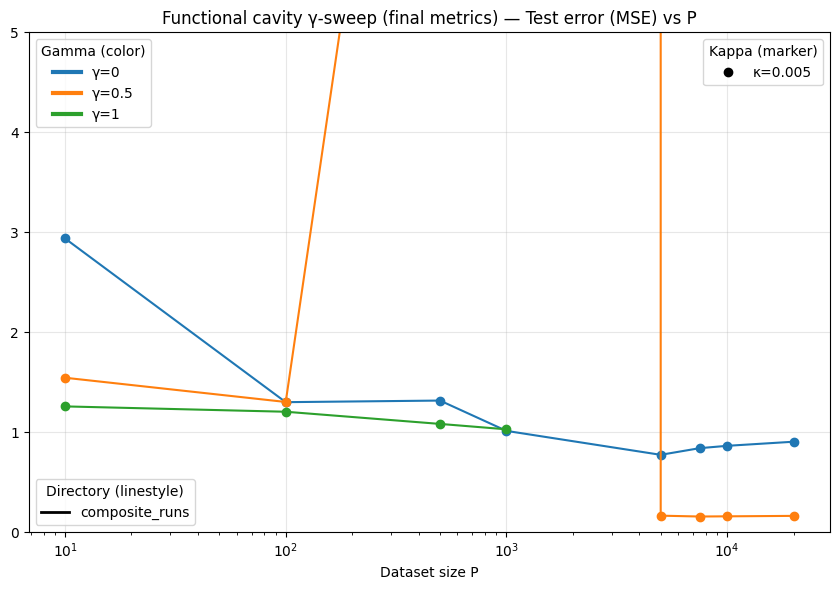

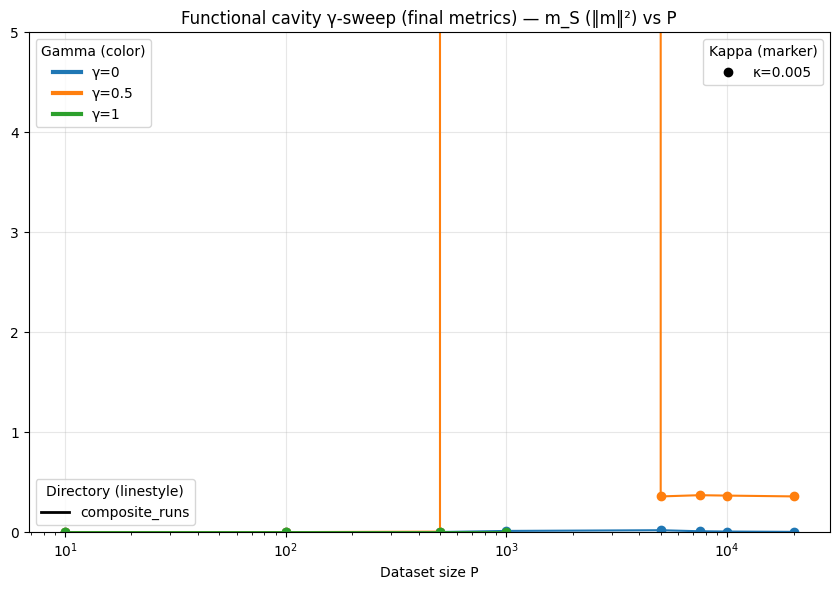

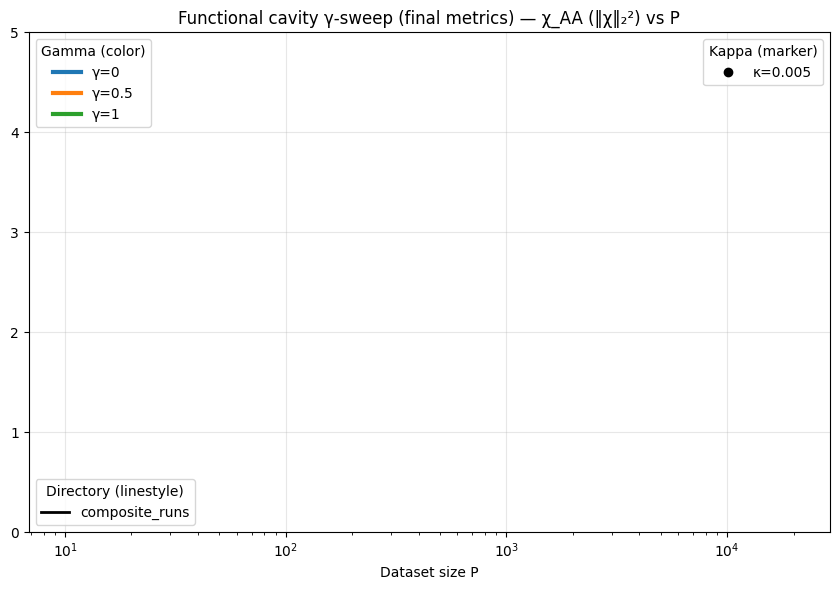

In [1]:
# --- New plotting helper: "by gamma"  ---------------------------------
import os, glob, json
from collections import defaultdict
from typing import Dict, Iterable, Tuple, Optional, Union, List
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# If your original has this already, you can remove this fallback.
def _coerce_dir_label_pairs(dirs_and_labels: Union[Dict[str, str], Iterable[Tuple[str, str]]]):
    if isinstance(dirs_and_labels, dict):
        return list(dirs_and_labels.items())
    return list(dirs_and_labels)

def _read_functional_cavity_metrics(path: str) -> Optional[dict]:
    """
    Read a single JSON produced by FunctionalCavitySolver.run(...) and
    normalize the fields we need for plotting.

    Returns a dict with keys:
      P (int), gamma (float), kappa (float),
      mse_total (float), mS_norm2 (float), chi_AA_norm2 (float)
    or None if the file doesn't match/has missing fields.
    """
    try:
        with open(path, "r") as f:
            data = json.load(f)
    except Exception:
        return None

    # Prefer "summary", then fallbacks
    summ = data.get("summary", {})
    cfg  = data.get("config", {})
    mdl  = (cfg.get("mdl", {}) if isinstance(cfg, dict) else {})
    # Extract core scalars robustly
    P = summ.get("P_train")
    if P is None:
        # Try filename heuristic: "..._P<digits>_Neval..."
        bn = os.path.basename(path)
        m = None
        import re
        m = re.search(r"_P(\d+)_", bn)
        if m:
            P = int(m.group(1))
    gamma = summ.get("gamma", mdl.get("gamma"))
    kappa = summ.get("kappa", cfg.get("kappa"))
    mse   = summ.get("mse_total_last", data.get("traj", {}).get("eval_mse_total", [None])[-1] if data.get("traj", {}).get("eval_mse_total") else None)
    mS2   = summ.get("mS_norm2_last")
    chi2  = summ.get("chi_AA_norm2_last")

    # Convert types safely
    def _as_float(x):
        try: return float(x)
        except Exception: return None
    def _as_int(x):
        try: return int(x)
        except Exception: return None

    P     = _as_int(P)
    gamma = _as_float(gamma)
    kappa = _as_float(kappa)
    mse   = _as_float(mse)
    mS2   = _as_float(mS2)
    chi2  = _as_float(chi2)

    if None in (P, gamma, kappa) or (mse is None and mS2 is None and chi2 is None):
        return None

    return {
        "P": P, "gamma": gamma, "kappa": kappa,
        "mse_total": mse, "mS_norm2": mS2, "chi_AA_norm2": chi2
    }

def _aggregate_by_gamma_kappa_P(rows: List[dict]) -> List[dict]:
    """
    Given list of normalized rows (see _read_functional_cavity_metrics),
    aggregate runs with the same (gamma, kappa, P).
    """
    bucket = defaultdict(list)
    for r in rows:
        key = (round(r["gamma"], 12), round(r["kappa"], 12), int(r["P"]))
        bucket[key].append(r)

    out = []
    for (gamma, kappa, P), group in bucket.items():
        def _collect(key):
            vals = [g[key] for g in group if g.get(key) is not None]
            if not vals:
                return None, None, 0
            arr = np.array(vals, dtype=float)
            return float(arr.mean()), float(arr.std(ddof=1) if arr.size > 1 else 0.0), int(arr.size)

        mse_mean,  mse_std,  n_mse  = _collect("mse_total")
        mS_mean,   mS_std,   n_mS   = _collect("mS_norm2")
        chi_mean,  chi_std,  n_chi  = _collect("chi_AA_norm2")

        out.append({
            "gamma": gamma, "kappa": kappa, "P": P,
            "mse_mean": mse_mean, "mse_std_over_runs": mse_std, "n_runs_mse": n_mse,
            "mS_mean":  mS_mean,  "mS_std_over_runs":  mS_std,  "n_runs_mS":  n_mS,
            "chi_mean": chi_mean, "chi_std_over_runs": chi_std, "n_runs_chi": n_chi,
        })
    return out

def make_plots_from_dirs_by_gamma(
    dirs_and_labels: Union[Dict[str, str], Iterable[Tuple[str, str]]],
    *,
    save_png: bool = True,
    out_prefix: str = "gamma_summary",
    verbose: bool = True,
    title_prefix: Optional[str] = None,
):
    """
    NEW: Build three separate figures vs P across multiple GAMMAs (colors),
         optionally multiple KAPPAs (markers), and directories (linestyles).

    Figures produced:
      1) Test error (MSE) vs P
      2) m_S (‖m‖²) vs P
      3) χ_AA (‖χ‖₂²) vs P

    Returns a dict with per-dir aggregates and figure handles.
    """
    pairs = _coerce_dir_label_pairs(dirs_and_labels)

    # 1) Collect & aggregate per directory
    per_dir_agg = {}
    for (results_dir, label) in pairs:
        paths = glob.glob(os.path.join(results_dir, "*.json"))
        rows = []
        for p in paths:
            r = _read_functional_cavity_metrics(p)
            if r is not None:
                rows.append(r)

        if not rows:
            if verbose:
                print(f"[warn] No usable result JSONs in {results_dir}")
            per_dir_agg[label] = []
            continue

        agg = _aggregate_by_gamma_kappa_P(rows)
        if verbose:
            print(f"--- {label} ({results_dir}) ---")
            for r in sorted(agg, key=lambda t: (t["gamma"], t["kappa"], t["P"])):
                gm = r["gamma"]; kp = r["kappa"]; P = r["P"]
                print(f"  γ={gm:g}  κ={kp:g}  P={P:>6d}  "
                      f"MSE={r['mse_mean']!s:>12}  m_S={r['mS_mean']!s:>12}  χ_AA={r['chi_mean']!s:>12}  "
                      f"runs(mse/mS/chi)={r['n_runs_mse']}/{r['n_runs_mS']}/{r['n_runs_chi']}")
        per_dir_agg[label] = agg

    # 2) Style maps
    # Colors by GAMMA
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', []) or [f"C{i}" for i in range(10)]
    gammas_all = sorted(set(round(r["gamma"], 12) for agg in per_dir_agg.values() for r in agg))
    gamma_color = {g: color_cycle[i % len(color_cycle)] for i, g in enumerate(gammas_all)}

    # Linestyles by DIRECTORY (label)
    linestyle_choices = [
        "-", "--", ":", "-.", (0, (3,1,1,1)), (0, (5,5)), (0, (1,1)), (0, (5,1)), (0,(2,2,1,2))
    ]
    dir_linestyle = {label: linestyle_choices[i % len(linestyle_choices)]
                     for i, (_, label) in enumerate(pairs)}

    # Markers by KAPPA
    marker_choices = ["o", "s", "D", "^", "v", "P", "X", "*", "h", "8"]
    kappas_all = sorted(set(round(r["kappa"], 12) for agg in per_dir_agg.values() for r in agg))
    kappa_marker = {k: marker_choices[i % len(marker_choices)] for i, k in enumerate(kappas_all)}

    # 3) Plot helpers
    def _plot_metric(metric_key_mean, metric_key_std, ylabel, out_name):
        fig, ax = plt.subplots(figsize=(8.5, 6))
        # keep track for legends
        used_gamma = set()
        used_kappa = set()
        used_dir   = set()

        for (results_dir, label) in pairs:
            agg = per_dir_agg.get(label, [])
            # group by (gamma, kappa)
            by_gk = defaultdict(list)
            for r in agg:
                by_gk[(r["gamma"], r["kappa"])].append(r)

            for (gamma, kappa), rows_gk in sorted(by_gk.items(), key=lambda t: (t[0][0], t[0][1])):
                rows_sorted = sorted(rows_gk, key=lambda r: r["P"])
                Ps   = np.array([r["P"] for r in rows_sorted], dtype=int)
                vals = np.array([r[metric_key_mean] for r in rows_sorted], dtype=float)
                yerr = np.array([r[metric_key_std] for r in rows_sorted], dtype=float)

                # Hide missing values (None) gracefully
                mask = np.isfinite(vals)
                if not mask.any():
                    continue
                Ps, vals, yerr = Ps[mask], vals[mask], yerr[mask]

                ax.errorbar(
                    Ps, vals, yerr=yerr, capsize=3,
                    marker=kappa_marker[round(kappa,12)],
                    linestyle=dir_linestyle[label],
                    color=gamma_color[round(gamma,12)],
                    label=None,
                )

                used_gamma.add(round(gamma,12))
                used_kappa.add(round(kappa,12))
                used_dir.add(label)

        ax.set_xscale("log")  # P usually spans decades; tweak if you prefer linear
        ax.set_xlabel("Dataset size P")
        ax.set_ylim(0,5)
        base_title = title_prefix or "Cavity functional summary"
        ax.set_title(f"{base_title} — {ylabel} vs P")
        ax.grid(True, alpha=0.3)

        # Legends
        gamma_handles = [Line2D([0],[0], color=gamma_color[g], lw=3, label=f"γ={g:g}") for g in gammas_all if g in used_gamma]
        kappa_handles = [Line2D([0],[0], marker=kappa_marker[k], linestyle="None", color="black", label=f"κ={k:g}") for k in kappas_all if k in used_kappa]
        dir_handles   = [Line2D([0],[0], color="black", linestyle=dir_linestyle[d], lw=2, label=d) for d in [lab for (_, lab) in pairs] if d in used_dir]

        # place 3 legends neatly
        if gamma_handles:
            leg1 = ax.legend(handles=gamma_handles, title="Gamma (color)", loc="upper left")
            ax.add_artist(leg1)
        if kappa_handles:
            leg2 = ax.legend(handles=kappa_handles, title="Kappa (marker)", loc="upper right")
            ax.add_artist(leg2)
        if dir_handles:
            ax.legend(handles=dir_handles, title="Directory (linestyle)", loc="lower left")

        fig.tight_layout()
        if save_png:
            out_path = f"{out_prefix}_{out_name}.png"
            fig.savefig(out_path, dpi=150)
            if verbose:
                print(f"[saved plot] {out_path}")
        return fig, ax

    # 4) Make the three separate figures
    fig_mse, ax_mse = _plot_metric("mse_mean", "mse_std_over_runs", "Test error (MSE)", "mse_vs_P")
    fig_mS,  ax_mS  = _plot_metric("mS_mean",  "mS_std_over_runs",  "m_S (‖m‖²)",     "mS_vs_P")
    fig_chi, ax_chi = _plot_metric("chi_mean", "chi_std_over_runs", "χ_AA (‖χ‖₂²)",  "chiAA_vs_P")

    return {
        "per_dir_agg": per_dir_agg,
        "figs": {
            "mse": (fig_mse, ax_mse),
            "mS":  (fig_mS,  ax_mS),
            "chi": (fig_chi, ax_chi),
        },
        "styles": {
            "gamma_color": gamma_color,
            "kappa_marker": kappa_marker,
            "dir_linestyle": dir_linestyle,
        },
        "values_present": {
            "gammas": gammas_all,
            "kappas": kappas_all,
        }
    }

# -------------- example usage (separate from your original) --------------
if __name__ == "__main__":
    pairs = [
        ("/home/goring/mean_field_langevin/MCMC_composite/results/2608__d35_k4_1", "composite_runs"),
        # add more result folders if you want distinct linestyles
    ]
    out = make_plots_from_dirs_by_gamma(
        pairs,
        save_png=True,
        out_prefix="functional_cavity_gamma_summaries",
        title_prefix="Functional cavity γ-sweep (final metrics)"
    )
    # In a notebook, you can display: out["figs"]["mse"][0], out["figs"]["mS"][0], out["figs"]["chi"][0]
